# Evaluation of LLM Performance on Känguru Tasks

In [1]:
# Read results parquet file for latest run and provide overview of dataset
import os
import pandas as pd

# Set run_designator to None for latest, or specify a run directory name
run_designator = "20251013_191510_openai-gpt-5"  # e.g., "20250929_175455_anthropic-claude-sonnet-4.5"

runs_dir = 'runs'
if run_designator is None:
    latest_run = max(os.listdir(runs_dir), key=lambda x: x)
else:
    latest_run = run_designator

results_file = os.path.join(runs_dir, latest_run, 'results.filled.parquet')

df = pd.read_parquet(results_file)
print("Dataset shape:", df.shape)
print("Columns:", list(df.columns))
print("Data types:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (3887, 32)
Columns: ['id', 'year', 'group', 'problem_number', 'language', 'multimodal', 'points', 'answer', 'predicted', 'is_correct', 'points_earned', 'reasoning_mode', 'latency_ms', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'reasoning_tokens', 'cached_prompt_tokens', 'audio_prompt_tokens', 'cost_usd', 'rationale', 'raw_text_response', 'generation_id', 'error', 'warnings', 'predicted_original', 'predicted_filled', 'filled_by_retry', 'filled_run_id', 'filled_timestamp', 'retry_attempt', 'retry_source']
Data types:
id                       object
year                     object
group                    object
problem_number           object
language                 object
multimodal                 bool
points                    int64
answer                   object
predicted                object
is_correct                 bool
points_earned           float64
reasoning_mode           object
latency_ms              float64
prompt_tokens           float64
compl

In [2]:
# Normalize predictions and derive helper columns for evaluation
import score_utils

# Standardize prediction labels
df['predicted_normalized'] = (
    df['predicted']
    .fillna('')
    .astype(str)
    .str.strip()
    .str.upper()
)

# Explicit attempt/decline semantics
# - has_answer: model produced a non-empty answer token
# - declined: model explicitly returned the DECLINED token
# - attempted: model produced an answer that was not an explicit decline
df['has_answer'] = df['predicted_normalized'] != ''
df['declined'] = df['predicted_normalized'] == score_utils.DECLINED_TOKEN
df['attempted'] = df['has_answer'] & (~df['declined'])

# Correctness flags (only meaningful for attempted items)
df['answered_correctly'] = df['is_correct'].fillna(False).astype(bool)
df['answered_incorrectly'] = df['attempted'] & (~df['answered_correctly'])

attempted_n = int(df['attempted'].sum())
declined_n = int(df['declined'].sum())
print(f"Questions attempted: {attempted_n}")
print(f"Declined questions (explicit): {declined_n} ({(df['declined'].mean() if len(df) else 0):.2%})")

Questions attempted: 3769
Declined questions (explicit): 118 (3.04%)


In [3]:
# Overall accuracy (counting attempted and declined)
overall_accuracy = df['answered_correctly'].mean() if attempted_n else 0
print(f"Overall accuracy (including declines): {overall_accuracy:.2%}")

Overall accuracy (including declines): 87.01%


In [4]:
# Unanswered questions (no output and not explicitly declined)
import pandas as pd

# A question is "unanswered" if the model provided no non-empty answer and did not explicitly decline
unanswered_mask = (~df['has_answer']) & (~df['declined'])
unanswered = df[unanswered_mask].copy()

print(f"Unanswered (no output, not declined): {len(unanswered)} / {len(df)} ({(len(unanswered)/len(df) if len(df) else 0):.2%})")

if unanswered.empty:
    print("No unanswered questions detected.")
else:
    cols = list(df.columns)
    cols_lower = {c.lower(): c for c in cols}

    # Identify candidate diagnostic columns that are actually present
    def first_present(names):
        for n in names:
            if n in cols_lower:
                return cols_lower[n]
        return None

    col_error = first_present(['error', 'exception', 'traceback', 'error_message'])
    col_status = first_present(['status', 'pipeline_status', 'result_status'])
    col_finish = first_present(['finish_reason', 'llm_finish_reason', 'reason'])
    col_raw_response = first_present(['raw_response', 'response'])
    col_output_tokens = first_present(['output_tokens', 'completion_tokens'])
    col_timeout = first_present(['timed_out', 'timeout'])

    present_diag_cols = [c for c in [col_error, col_status, col_finish, col_raw_response, col_output_tokens, col_timeout] if c]
    if present_diag_cols:
        print("\nDiagnostic columns used:", present_diag_cols)
    else:
        print("\nNo diagnostic columns present; will default causes to 'no_output'.")

    def to_str(x):
        try:
            return str(x)
        except Exception:
            return ''

    def infer_cause(row):
        # 1) explicit error/exception
        if col_error is not None:
            val = row.get(col_error)
            if pd.notna(val) and to_str(val).strip():
                return 'error'
        # 2) timeout flags
        if col_timeout is not None:
            val = row.get(col_timeout)
            sval = to_str(val).strip().lower()
            if (isinstance(val, bool) and val) or sval in ('1', 'true', 'timeout', 'timed_out'):
                return 'timeout'
        # 3) non-OK status values
        if col_status is not None:
            sval = to_str(row.get(col_status)).strip().lower()
            if sval and sval not in ('', 'ok', 'success', 'none', 'nan'):
                return f"status:{sval}"
        # 4) model finish reasons (e.g., length/content_filter)
        if col_finish is not None:
            fr = to_str(row.get(col_finish)).strip().lower()
            if fr:
                return f"finish:{fr}"
        # 5) missing API response object
        if col_raw_response is not None:
            val = row.get(col_raw_response)
            if pd.isna(val):
                return 'no_api_response'
        # 6) zero output tokens
        if col_output_tokens is not None:
            try:
                tok = pd.to_numeric(row.get(col_output_tokens))
                if pd.notna(tok) and float(tok) == 0.0:
                    return 'empty_output'
            except Exception:
                pass
        # default
        return 'no_output'

    causes = unanswered.apply(infer_cause, axis=1)
    unanswered_display = unanswered.copy()
    unanswered_display['cause'] = causes

    print("\nCauses (inferred):")
    print(causes.value_counts().to_string())

    # Choose important columns to display
    base_cols = ['id', 'year', 'group', 'problem_number', 'multimodal', 'points', 'predicted', 'predicted_normalized']
    display_cols = [c for c in base_cols if c in unanswered_display.columns] + ['cause']

    # Show a concise table of all unanswered questions
    print("\nList of unanswered questions (full list):")
    try:
        from IPython.display import display
        display(unanswered_display[display_cols].reset_index(drop=True))
    except Exception:
        print(unanswered_display[display_cols].reset_index(drop=True).to_string(index=False))

    # Also print a compact preview
    preview_cols = [c for c in ['id', 'year', 'group', 'problem_number', 'cause'] if c in unanswered_display.columns]
    if preview_cols:
        print("\nPreview (first 10):")
        print(unanswered_display[preview_cols].head(10).to_string(index=False))


Unanswered (no output, not declined): 0 / 3887 (0.00%)
No unanswered questions detected.


In [5]:
# Print 10 random samples of the 'points_earned' column
print("10 random samples of 'points_earned':")
print(df['points_earned'].sample(10, random_state=1))

10 random samples of 'points_earned':
3620    0.00
2420    5.00
1060    3.00
1087   -1.25
990     3.00
2425    3.00
3790    5.00
808     3.00
610     5.00
1566    5.00
Name: points_earned, dtype: float64


## Score overview

In [6]:
# Compute exam-level scores and overall total
import pandas as pd
import score_utils

# Group by year and grade to calculate scores per exam
tuples = [(year, grp) for year, grp in df[['year','group']].drop_duplicates().itertuples(index=False)]
exam_scores = []
for year, grp in tuples:
    subset = df[(df['year'] == year) & (df['group'] == grp)]
    start_pts = score_utils.start_points_for_group(grp)
    earned_pts = subset['points_earned'].sum()
    total_exam = start_pts + earned_pts
    exam_scores.append({
        'year': year,
        'group': grp,
        'start_points': start_pts,
        'earned_points': earned_pts,
        'total_score': total_exam
    })

exam_scores_df = pd.DataFrame(exam_scores)

# Sort by year and then by the minimum grade number in each group
def get_min_grade(group_value):
    grades = score_utils.extract_grade_numbers(group_value)
    return min(grades) if grades else 0

exam_scores_df['_sort_key'] = exam_scores_df['group'].apply(get_min_grade)
exam_scores_df = exam_scores_df.sort_values(['year', '_sort_key']).drop(columns=['_sort_key']).reset_index(drop=True)

print('Exam-level scores:')
print(exam_scores_df)
print('Years in exam scores:', exam_scores_df['year'].unique())
print('Sample exam scores:')
print(exam_scores_df.sample(5, random_state=1))

overall_total = exam_scores_df['total_score'].sum()
print(f'Overall total score across all exams: {overall_total}')

# Unified accuracy semantics: use overall recall (correct / total), not attempted-only
total_questions = len(df)
attempted_questions = int(df['attempted'].sum())
declined_total = int(df['declined'].sum())
correct_count = int(df['answered_correctly'].sum())
overall_accuracy = (correct_count / total_questions) if total_questions > 0 else 0.0
print(f'Overall accuracy (recall): {overall_accuracy:.2%} ({correct_count}/{total_questions}). Attempted = {attempted_questions}/{total_questions}; Declined (explicit) = {declined_total}.')


Exam-level scores:
     year  group  start_points  earned_points  total_score
0    1998    3-4          24.0          45.00        69.00
1    1998    5-6          24.0         107.25       131.25
2    1998    7-8          30.0          97.00       127.00
3    1998   9-10          30.0         115.00       145.00
4    1998  11-13          30.0         107.00       137.00
..    ...    ...           ...            ...          ...
135  2025    3-4          24.0          74.75        98.75
136  2025    5-6          24.0          75.75        99.75
137  2025    7-8          30.0         110.00       140.00
138  2025   9-10          30.0         108.25       138.25
139  2025  11-13          30.0          97.00       127.00

[140 rows x 5 columns]
Years in exam scores: ['1998' '1999' '2000' '2001' '2002' '2003' '2004' '2005' '2006' '2007'
 '2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017'
 '2018' '2019' '2020' '2021' '2022' '2023' '2024' '2025']
Sample exam scores:
     ye

In [7]:
# Declined answer diagnostics
from IPython.display import display
import score_utils

declined_df = df[df['declined']].copy()
total_questions = len(df)

if declined_df.empty:
    print("Declined questions: 0 (0.00% of all questions)")
else:
    def grade_midpoint(group_value):
        numbers = score_utils.extract_grade_numbers(group_value)
        if not numbers:
            return None
        return sum(numbers) / len(numbers)

    declined_df['grade_midpoint'] = declined_df['group'].apply(grade_midpoint)
    modality_labels = {True: 'Multimodal', False: 'Text-only'}
    modality_summary = (
        declined_df
        .assign(modality=declined_df['multimodal'].map(modality_labels))
        .groupby('modality')
        .agg(
            count=('id', 'size'),
            avg_points=('points', 'mean'),
            median_points=('points', 'median'),
        )
        .assign(share=lambda d: d['count'] / len(declined_df))
        .sort_values('count', ascending=False)
    )

    share = len(declined_df) / total_questions if total_questions else 0.0
    print(f"Declined questions: {len(declined_df)} ({share:.2%} of all questions)")
    print("Declined questions by modality (count, share, avg/median task points):")
    display(modality_summary)

    grade_series = declined_df['grade_midpoint'].dropna()
    if not grade_series.empty:
        print(f"Average grade (midpoint): {grade_series.mean():.2f}; Median grade (midpoint): {grade_series.median():.2f}")
    else:
        print("Average grade (midpoint): n/a; Median grade (midpoint): n/a")

    print(f"Average task points available: {declined_df['points'].mean():.2f}; Median: {declined_df['points'].median():.2f}")


Declined questions: 118 (3.04% of all questions)
Declined questions by modality (count, share, avg/median task points):


,count,avg_points,median_points,share
modality,,,,
Multimodal,108,4.037037,4.0,0.915254
Text-only,10,4.000000,4.0,0.084746


Average grade (midpoint): 7.18; Median grade (midpoint): 7.50
Average task points available: 4.03; Median: 4.00


## Multimodal vs Text-only Performance

In [8]:
# Multimodal share
multimodal_df = df[df['multimodal']].copy()
total_questions = len(df)
multimodal_questions = len(multimodal_df)
multimodal_share = multimodal_questions / total_questions * 100 if total_questions > 0 else 0

print(f"Multimodal questions: {multimodal_questions} / {total_questions} ({multimodal_share:.2f}%)")

Multimodal questions: 1747 / 3887 (44.94%)


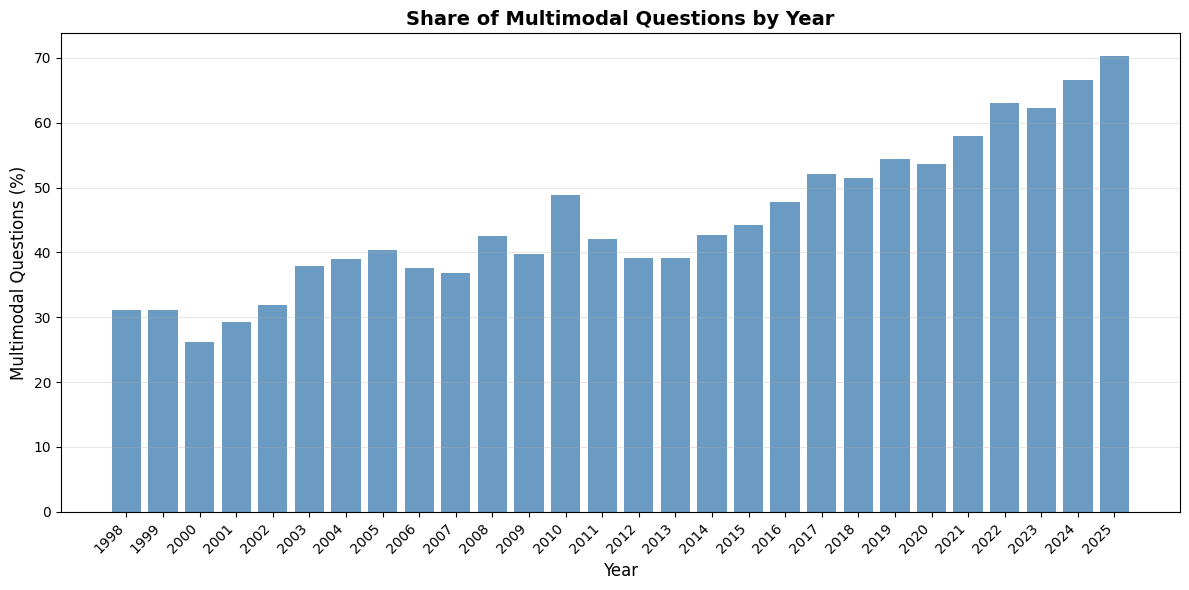


Yearly Multimodal Shares:
year  multimodal_count  total_count  multimodal_share
1998                42          135         31.111111
1999                42          135         31.111111
2000                37          141         26.241135
2001                41          140         29.285714
2002                45          141         31.914894
2003                53          140         37.857143
2004                55          141         39.007092
2005                57          141         40.425532
2006                53          141         37.588652
2007                52          141         36.879433
2008                60          141         42.553191
2009                56          141         39.716312
2010                68          139         48.920863
2011                58          138         42.028986
2012                54          138         39.130435
2013                54          138         39.130435
2014                59          138         42.753623
2

In [9]:
# Visualization: Yearly shares of multimodal questions
import matplotlib.pyplot as plt

# Calculate multimodal share per year
yearly_multimodal = df.groupby('year').agg({
    'multimodal': ['sum', 'count']
}).reset_index()
yearly_multimodal.columns = ['year', 'multimodal_count', 'total_count']
yearly_multimodal['multimodal_share'] = (yearly_multimodal['multimodal_count'] / yearly_multimodal['total_count']) * 100

# Sort by year
yearly_multimodal = yearly_multimodal.sort_values('year')

# Create column chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(yearly_multimodal['year'].astype(str), yearly_multimodal['multimodal_share'], color='steelblue', alpha=0.8)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Multimodal Questions (%)', fontsize=12)
ax.set_title('Share of Multimodal Questions by Year', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nYearly Multimodal Shares:")
print(yearly_multimodal.to_string(index=False))

In [10]:
# Multimodal vs Text-only performance (unified semantics)
# Report recall (correct/total), attempt rate, and decline counts

multi_total = int((df['multimodal'] == True).sum())
text_total = int((df['multimodal'] == False).sum())

# Multimodal
mm = df[df['multimodal'] == True]
mm_correct = int(mm['answered_correctly'].sum())
mm_attempted = int(mm['attempted'].sum())
mm_declined = int(mm['declined'].sum())
mm_recall = (mm_correct / len(mm)) if len(mm) > 0 else 0.0
mm_attempt_rate = (mm_attempted / len(mm)) if len(mm) > 0 else 0.0
print("Multimodal:")
print(f"  Recall (correct/total): {mm_recall:.2%} ({mm_correct}/{len(mm)})")
print(f"  Attempt rate: {mm_attempt_rate:.2%} ({mm_attempted}/{len(mm)}); Declined (explicit): {mm_declined}")

# Text-only
tx = df[df['multimodal'] == False]
tx_correct = int(tx['answered_correctly'].sum())
tx_attempted = int(tx['attempted'].sum())
tx_declined = int(tx['declined'].sum())
tx_recall = (tx_correct / len(tx)) if len(tx) > 0 else 0.0
tx_attempt_rate = (tx_attempted / len(tx)) if len(tx) > 0 else 0.0
print("Text-only:")
print(f"  Recall (correct/total): {tx_recall:.2%} ({tx_correct}/{len(tx)})")
print(f"  Attempt rate: {tx_attempt_rate:.2%} ({tx_attempted}/{len(tx)}); Declined (explicit): {tx_declined}")


Multimodal:
  Recall (correct/total): 74.59% (1303/1747)
  Attempt rate: 93.82% (1639/1747); Declined (explicit): 108
Text-only:
  Recall (correct/total): 97.15% (2079/2140)
  Attempt rate: 99.53% (2130/2140); Declined (explicit): 10


## Grade-based Performance

In [11]:
# Grade-based performance
# Report recall (correct/total), attempt rate, and declined counts per grade

grades = sorted(df['group'].unique(), key=lambda x: int(x.split('-')[0]))
for grade in grades:
    grade_df = df[df['group'] == grade]
    total_n = len(grade_df)
    correct = int(grade_df['answered_correctly'].sum())
    attempted = int(grade_df['attempted'].sum())
    declined_grade = int(grade_df['declined'].sum())
    recall = (correct / total_n) if total_n > 0 else 0.0
    attempt_rate = (attempted / total_n) if total_n > 0 else 0.0
    print(f"Grade {grade}: recall = {recall:.2%} ({correct}/{total_n}); attempts = {attempted} ({attempt_rate:.2%}); declined = {declined_grade}.")

print()

# Percentage of multimodal questions per grade
for grade in grades:
    grade_df = df[df['group'] == grade]
    if not grade_df.empty:
        multimodal_grade_df = grade_df[grade_df['multimodal'] == True]
        share = len(multimodal_grade_df) / len(grade_df) * 100.0
        print(f"Share of multimodal questions in grade {grade}: {share:.2f}% ({len(multimodal_grade_df)}/{len(grade_df)}).")


Grade 3-4: recall = 79.45% (495/623); attempts = 599 (96.15%); declined = 24.
Grade 5-6: recall = 82.95% (618/745); attempts = 717 (96.24%); declined = 28.
Grade 7-8: recall = 89.29% (750/840); attempts = 811 (96.55%); declined = 29.
Grade 9-10: recall = 92.25% (774/839); attempts = 818 (97.50%); declined = 21.
Grade 11-13: recall = 88.69% (745/840); attempts = 824 (98.10%); declined = 16.

Share of multimodal questions in grade 3-4: 55.38% (345/623).
Share of multimodal questions in grade 5-6: 52.48% (391/745).
Share of multimodal questions in grade 7-8: 43.81% (368/840).
Share of multimodal questions in grade 9-10: 38.86% (326/839).
Share of multimodal questions in grade 11-13: 37.74% (317/840).


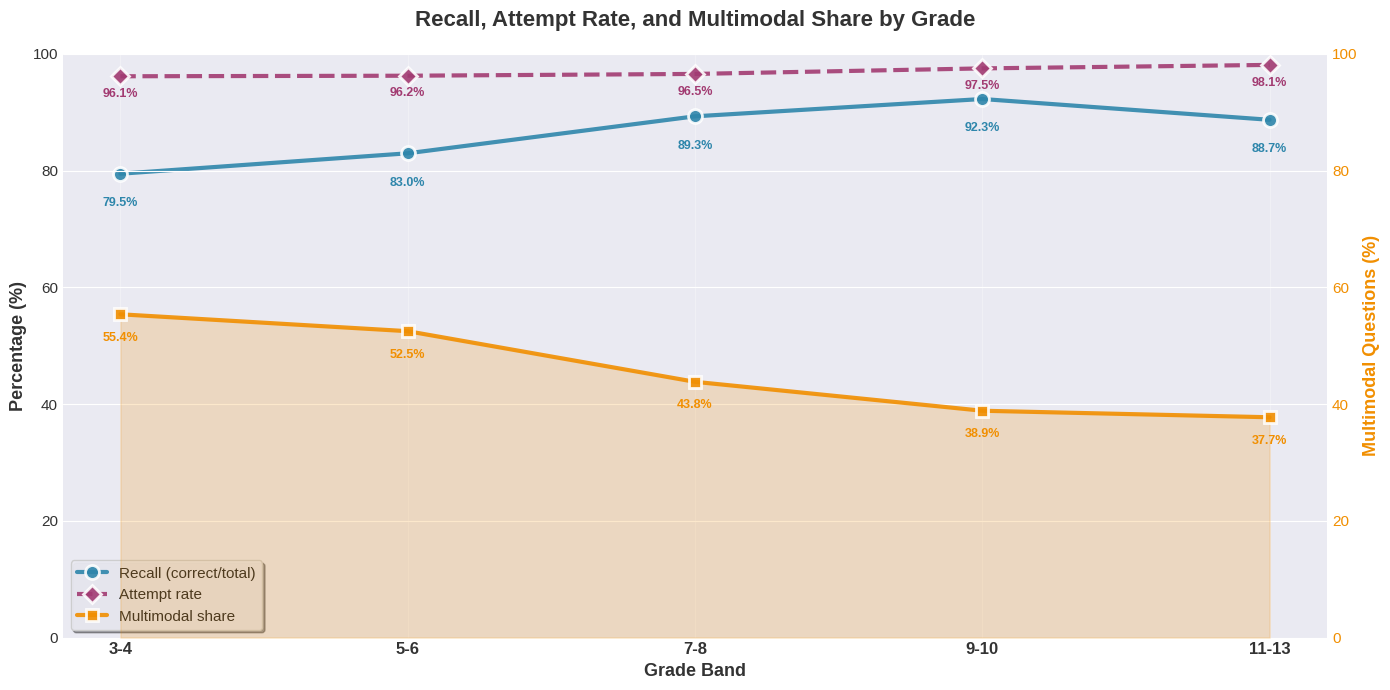

In [12]:
# Visualization: Recall and Multimodal Share by Grade
import matplotlib.pyplot as plt
import numpy as np

# Collect data for each grade
grade_data = {
    'grade': [],
    'recall_pct': [],  # correct / total
    'attempt_rate_pct': [],  # attempted / total
    'multimodal_share': []
}

for grade in grades:
    grade_df = df[df['group'] == grade]
    total_n = len(grade_df)

    # Recall (overall correctness)
    total_correct = int(grade_df['answered_correctly'].sum())
    recall = (total_correct / total_n) if total_n > 0 else 0.0

    # Attempt rate
    attempted_n = int(grade_df['attempted'].sum())
    attempt_rate = (attempted_n / total_n) if total_n > 0 else 0.0

    # Multimodal share
    multimodal_grade_df = grade_df[grade_df['multimodal'] == True]
    multimodal_share = len(multimodal_grade_df) / total_n * 100.0 if total_n > 0 else 0.0

    grade_data['grade'].append(grade)
    grade_data['recall_pct'].append(recall * 100)
    grade_data['attempt_rate_pct'].append(attempt_rate * 100)
    grade_data['multimodal_share'].append(multimodal_share)

# Set style for better aesthetics
plt.style.use('seaborn-v0_8-darkgrid')

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor('white')

x = np.arange(len(grades))

# Color scheme - more professional and distinct
colors = {
    'recall': '#2E86AB',      # Blue
    'attempt_rate': '#A23B72',  # Purple-magenta
    'multimodal': '#F18F01'  # Warm orange
}

# Left y-axis for percentages
ax1.set_xlabel('Grade Band', fontsize=13, fontweight='bold', color='#333333')
ax1.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold', color='#333333')

# Plot recall and attempt rate
line1 = ax1.plot(x, grade_data['recall_pct'], 
                 marker='o', color=colors['recall'], linewidth=3, 
                 label='Recall (correct/total)', markersize=10, 
                 markeredgewidth=2, markeredgecolor='white',
                 alpha=0.9, zorder=3)

line2 = ax1.plot(x, grade_data['attempt_rate_pct'], 
                 marker='D', color=colors['attempt_rate'], linewidth=3, 
                 label='Attempt rate', markersize=9, 
                 markeredgewidth=2, markeredgecolor='white',
                 linestyle='--', alpha=0.9, zorder=3)

# Add value labels on the lines
for i, (recall_v, attempt_v) in enumerate(zip(grade_data['recall_pct'], grade_data['attempt_rate_pct'])):
    ax1.text(i, recall_v - 4, f'{recall_v:.1f}%', ha='center', va='top', 
             fontsize=9, color=colors['recall'], fontweight='bold')
    ax1.text(i, attempt_v - 2, f'{attempt_v:.1f}%', ha='center', va='top', 
             fontsize=9, color=colors['attempt_rate'], fontweight='bold')

ax1.set_ylim([0, 100])
ax1.tick_params(axis='y', labelsize=11, colors='#333333')
ax1.tick_params(axis='x', labelsize=11, colors='#333333')
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8, zorder=0)
ax1.set_axisbelow(True)

# Right y-axis for multimodal share with area fill
ax2 = ax1.twinx()
ax2.set_ylabel('Multimodal Questions (%)', fontsize=13, fontweight='bold', color=colors['multimodal'])

# Plot multimodal share as filled area for visual distinction
ax2.fill_between(x, grade_data['multimodal_share'], alpha=0.2, color=colors['multimodal'], zorder=1)
line3 = ax2.plot(x, grade_data['multimodal_share'], 
                 marker='s', color=colors['multimodal'], linewidth=3, 
                 label='Multimodal share', markersize=9,
                 markeredgewidth=2, markeredgecolor='white',
                 alpha=0.9, zorder=2)

# Add value labels for multimodal share
for i, mm_share in enumerate(grade_data['multimodal_share']):
    ax2.text(i, mm_share - 3, f'{mm_share:.1f}%', ha='center', va='top',
             fontsize=9, color=colors['multimodal'], fontweight='bold')

ax2.set_ylim([0, 100])
ax2.tick_params(axis='y', labelsize=11, labelcolor=colors['multimodal'])

# Set x-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(grades, fontsize=12, fontweight='bold')

# Enhanced legend with better positioning
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='lower left', fontsize=11, 
                    frameon=True, fancybox=True, shadow=True,
                    edgecolor='#CCCCCC', framealpha=0.95)

# Title with better styling
plt.title('Recall, Attempt Rate, and Multimodal Share by Grade', 
          fontsize=16, fontweight='bold', pad=20, color='#333333')

fig.tight_layout()
plt.show()

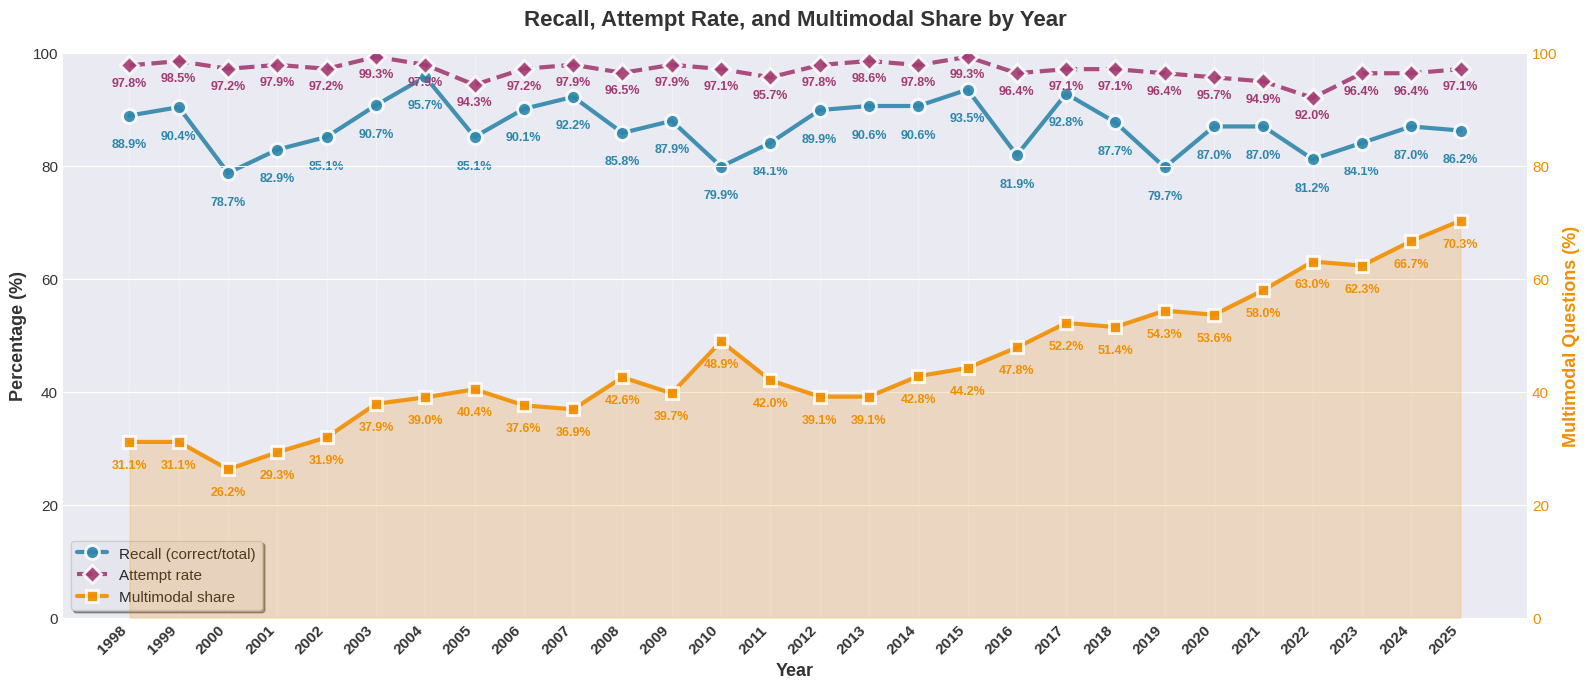

In [13]:
# Visualization: Recall and Multimodal Share by Year
import matplotlib.pyplot as plt
import numpy as np

# Get unique years and sort them
years = sorted(df['year'].unique())

# Collect data for each year
year_data = {
    'year': [],
    'recall_pct': [],  # correct / total
    'attempt_rate_pct': [],  # attempted / total
    'multimodal_share': []
}

for year in years:
    year_df = df[df['year'] == year]
    total_n = len(year_df)

    # Recall (overall correctness)
    total_correct = int(year_df['answered_correctly'].sum())
    recall = (total_correct / total_n) if total_n > 0 else 0.0

    # Attempt rate
    attempted_n = int(year_df['attempted'].sum())
    attempt_rate = (attempted_n / total_n) if total_n > 0 else 0.0

    # Multimodal share
    multimodal_year_df = year_df[year_df['multimodal'] == True]
    multimodal_share = len(multimodal_year_df) / total_n * 100.0 if total_n > 0 else 0.0

    year_data['year'].append(year)
    year_data['recall_pct'].append(recall * 100)
    year_data['attempt_rate_pct'].append(attempt_rate * 100)
    year_data['multimodal_share'].append(multimodal_share)

# Set style for better aesthetics
plt.style.use('seaborn-v0_8-darkgrid')

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(16, 7))
fig.patch.set_facecolor('white')

x = np.arange(len(years))

# Color scheme - more professional and distinct
colors = {
    'recall': '#2E86AB',      # Blue
    'attempt_rate': '#A23B72',  # Purple-magenta
    'multimodal': '#F18F01'  # Warm orange
}

# Left y-axis for percentages
ax1.set_xlabel('Year', fontsize=13, fontweight='bold', color='#333333')
ax1.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold', color='#333333')

# Plot recall and attempt rate
line1 = ax1.plot(x, year_data['recall_pct'], 
                 marker='o', color=colors['recall'], linewidth=3, 
                 label='Recall (correct/total)', markersize=10, 
                 markeredgewidth=2, markeredgecolor='white',
                 alpha=0.9, zorder=3)

line2 = ax1.plot(x, year_data['attempt_rate_pct'], 
                 marker='D', color=colors['attempt_rate'], linewidth=3, 
                 label='Attempt rate', markersize=9, 
                 markeredgewidth=2, markeredgecolor='white',
                 linestyle='--', alpha=0.9, zorder=3)

# Add value labels on the lines
for i, (recall_v, attempt_v) in enumerate(zip(year_data['recall_pct'], year_data['attempt_rate_pct'])):
    ax1.text(i, recall_v - 4, f'{recall_v:.1f}%', ha='center', va='top', 
             fontsize=9, color=colors['recall'], fontweight='bold')
    ax1.text(i, attempt_v - 2, f'{attempt_v:.1f}%', ha='center', va='top', 
             fontsize=9, color=colors['attempt_rate'], fontweight='bold')

ax1.set_ylim([0, 100])
ax1.tick_params(axis='y', labelsize=11, colors='#333333')
ax1.tick_params(axis='x', labelsize=11, colors='#333333')
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8, zorder=0)
ax1.set_axisbelow(True)

# Right y-axis for multimodal share with area fill
ax2 = ax1.twinx()
ax2.set_ylabel('Multimodal Questions (%)', fontsize=13, fontweight='bold', color=colors['multimodal'])

# Plot multimodal share as filled area for visual distinction
ax2.fill_between(x, year_data['multimodal_share'], alpha=0.2, color=colors['multimodal'], zorder=1)
line3 = ax2.plot(x, year_data['multimodal_share'], 
                 marker='s', color=colors['multimodal'], linewidth=3, 
                 label='Multimodal share', markersize=9,
                 markeredgewidth=2, markeredgecolor='white',
                 alpha=0.9, zorder=2)

# Add value labels for multimodal share
for i, mm_share in enumerate(year_data['multimodal_share']):
    ax2.text(i, mm_share - 3, f'{mm_share:.1f}%', ha='center', va='top',
             fontsize=9, color=colors['multimodal'], fontweight='bold')

ax2.set_ylim([0, 100])
ax2.tick_params(axis='y', labelsize=11, labelcolor=colors['multimodal'])

# Set x-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(years, fontsize=11, fontweight='bold', rotation=45, ha='right')

# Enhanced legend with better positioning
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='lower left', fontsize=11, 
                    frameon=True, fancybox=True, shadow=True,
                    edgecolor='#CCCCCC', framealpha=0.95)

# Title with better styling
plt.title('Recall, Attempt Rate, and Multimodal Share by Year', 
          fontsize=16, fontweight='bold', pad=20, color='#333333')

fig.tight_layout()
plt.show()

MULTIMODAL QUESTIONS: DIFFICULTY BY POINT VALUE (single analysis)
  3 pts: recall 74.9% (n=602, attempts 94.0%)
  4 pts: recall 74.5% (n=589, attempts 94.6%)
  5 pts: recall 74.3% (n=556, attempts 92.8%)

Correlation (Points vs Recall): r = -0.993, p = 0.0755


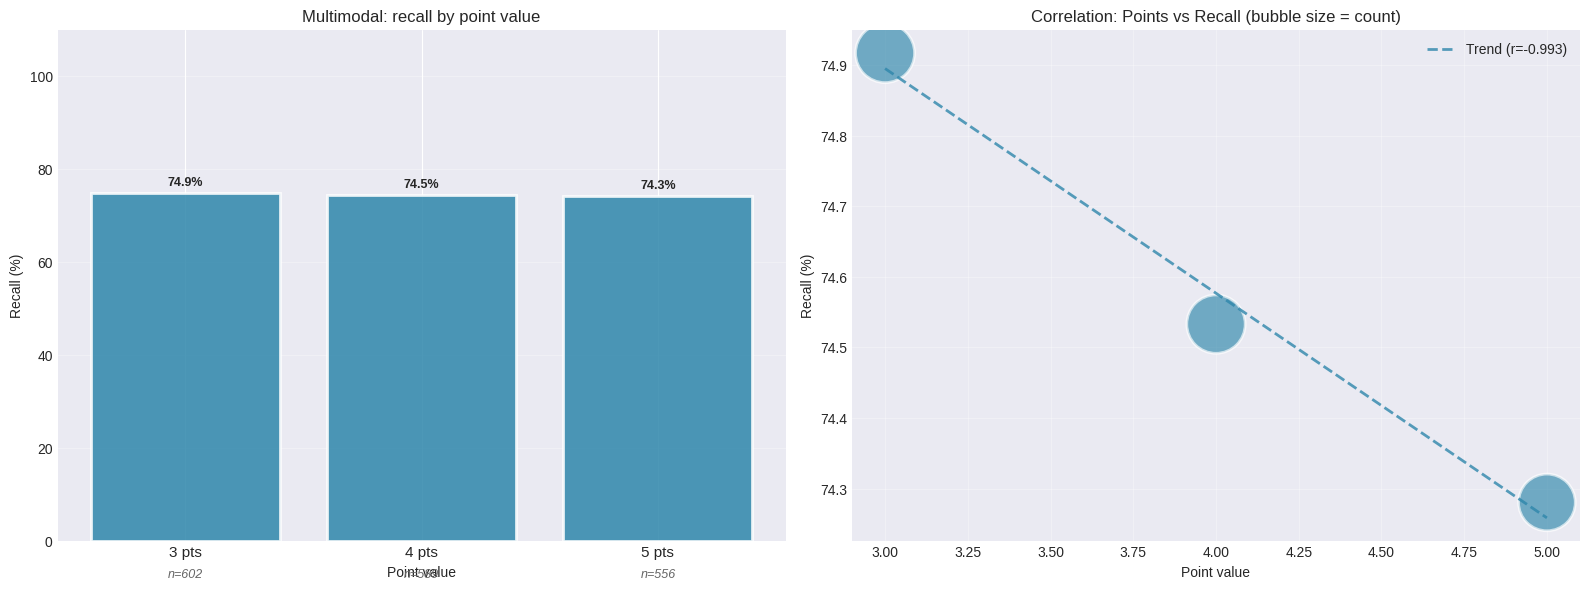

In [14]:
# Analysis: Are higher-point multimodal questions more difficult for the LLM?
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Filter for multimodal questions only
multimodal_df = df[df['multimodal'] == True].copy()

# Group by point values and calculate recall (correct/total) and attempt rate
points_analysis = []
for points in sorted(multimodal_df['points'].unique()):
    pts_df = multimodal_df[multimodal_df['points'] == points]

    total_questions = len(pts_df)
    correct = pts_df['answered_correctly'].sum()
    recall = (correct / total_questions * 100) if total_questions > 0 else 0

    attempted_n = pts_df['attempted'].sum()
    attempt_rate = (attempted_n / total_questions * 100) if total_questions > 0 else 0

    points_analysis.append({
        'points': points,
        'recall': recall,
        'attempt_rate': attempt_rate,
        'count': total_questions,
    })

analysis_df = pd.DataFrame(points_analysis)

# Correlation between points and recall
r_value, p_value = stats.pearsonr(analysis_df['points'], analysis_df['recall'])
print("=" * 70)
print("MULTIMODAL QUESTIONS: DIFFICULTY BY POINT VALUE (single analysis)")
print("=" * 70)
for _, row in analysis_df.iterrows():
    print(f"  {int(row['points'])} pts: recall {row['recall']:.1f}% (n={int(row['count'])}, attempts {row['attempt_rate']:.1f}%)")
print(f"\nCorrelation (Points vs Recall): r = {r_value:.3f}, p = {p_value:.4f}")

# Visualization: bar + scatter with one trend line
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('white')

# Bar: recall by point value
x_pos = np.arange(len(analysis_df))
ax1.bar(x_pos, analysis_df['recall'], color='#2E86AB', alpha=0.85, edgecolor='white', linewidth=2)
for i, (recall, cnt) in enumerate(zip(analysis_df['recall'], analysis_df['count'])):
    ax1.text(i, recall + 1, f'{recall:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax1.text(i, -6, f'n={int(cnt)}', ha='center', va='top', fontsize=9, style='italic', color='#666666')
ax1.set_xlabel('Point value')
ax1.set_ylabel('Recall (%)')
ax1.set_title('Multimodal: recall by point value')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'{int(p)} pts' for p in analysis_df['points']], fontsize=11)
ax1.set_ylim([0, 110])
ax1.grid(axis='y', alpha=0.3)
ax1.set_axisbelow(True)

# Scatter: points vs recall + trend
ax2.scatter(analysis_df['points'], analysis_df['recall'], s=analysis_df['count']*3, alpha=0.65, color='#2E86AB', edgecolors='white', linewidth=2)
z = np.polyfit(analysis_df['points'], analysis_df['recall'], 1)
p = np.poly1d(z)
x_line = np.linspace(analysis_df['points'].min(), analysis_df['points'].max(), 100)
ax2.plot(x_line, p(x_line), '--', color='#2E86AB', linewidth=2, alpha=0.8, label=f'Trend (r={r_value:.3f})')
ax2.set_xlabel('Point value')
ax2.set_ylabel('Recall (%)')
ax2.set_title('Correlation: Points vs Recall (bubble size = count)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_axisbelow(True)

plt.tight_layout()
plt.show()


MULTIMODAL QUESTIONS: DIFFICULTY BY GRADE (single analysis)
  Grade 3-4: recall 65.8% (n=345, attempts 93.0%)
  Grade 5-6: recall 69.1% (n=391, attempts 92.8%)
  Grade 7-8: recall 78.3% (n=368, attempts 93.2%)
  Grade 9-10: recall 81.9% (n=326, attempts 94.5%)
  Grade 11-13: recall 79.2% (n=317, attempts 95.9%)

Correlation (Grade vs Recall): r = 0.896, p = 0.0399


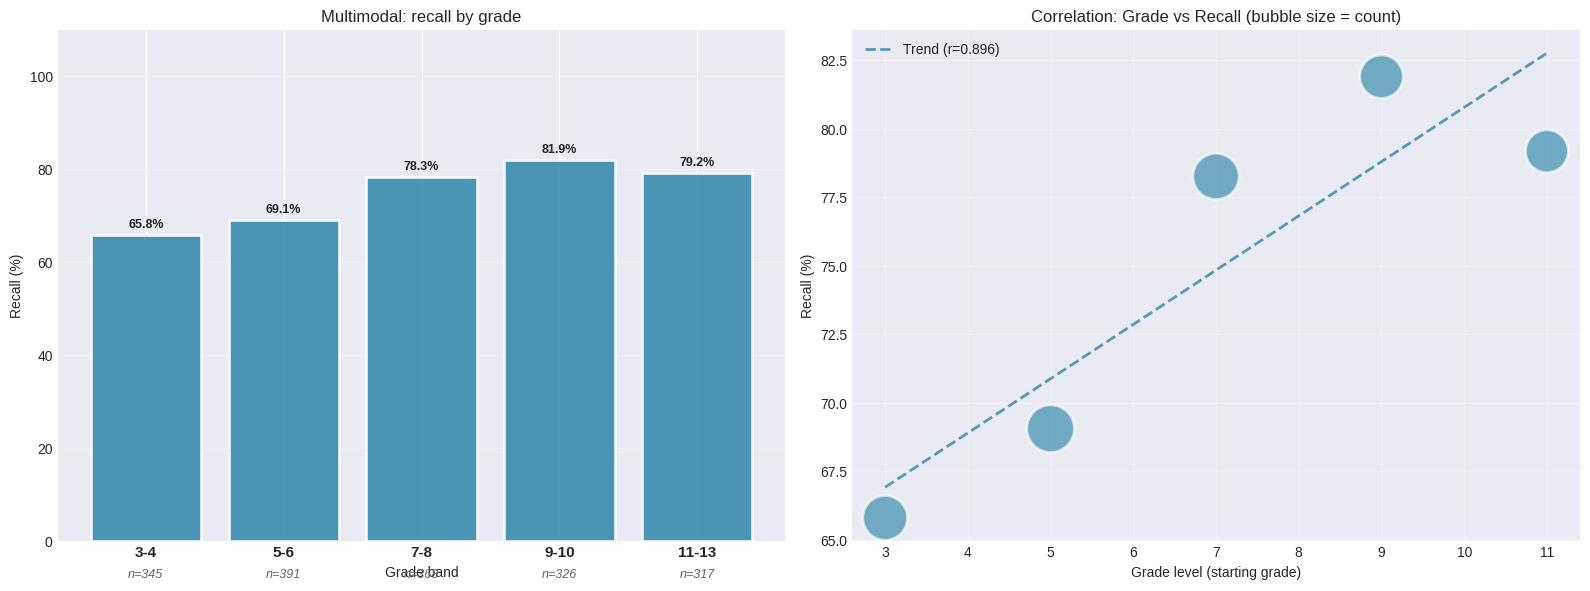

In [15]:
# Analysis: Are multimodal questions in higher grades more difficult for the LLM?
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

multimodal_df = df[df['multimodal'] == True].copy()

grade_analysis = []
for grade in grades:
    gdf = multimodal_df[multimodal_df['group'] == grade]
    if len(gdf) == 0:
        continue
    total = len(gdf)
    correct = gdf['answered_correctly'].sum()
    recall = (correct / total * 100) if total > 0 else 0
    attempted = gdf['attempted'].sum()
    attempt_rate = (attempted / total * 100) if total > 0 else 0
    grade_analysis.append({
        'grade': grade,
        'grade_order': int(grade.split('-')[0]),
        'recall': recall,
        'attempt_rate': attempt_rate,
        'count': total,
    })

grade_analysis_df = pd.DataFrame(grade_analysis).sort_values('grade_order')

grade_numeric = grade_analysis_df['grade_order'].values
recall_vals = grade_analysis_df['recall'].values
r_value, p_value = stats.pearsonr(grade_numeric, recall_vals)

print("=" * 70)
print("MULTIMODAL QUESTIONS: DIFFICULTY BY GRADE (single analysis)")
print("=" * 70)
for _, row in grade_analysis_df.iterrows():
    print(f"  Grade {row['grade']}: recall {row['recall']:.1f}% (n={int(row['count'])}, attempts {row['attempt_rate']:.1f}%)")
print(f"\nCorrelation (Grade vs Recall): r = {r_value:.3f}, p = {p_value:.4f}")

# Visualization: bar + scatter with trend
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('white')

# Bar chart
x_pos = np.arange(len(grade_analysis_df))
ax1.bar(x_pos, grade_analysis_df['recall'], color='#2E86AB', alpha=0.85, edgecolor='white', linewidth=2)
for i, (recall, cnt) in enumerate(zip(grade_analysis_df['recall'], grade_analysis_df['count'])):
    ax1.text(i, recall + 1, f'{recall:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax1.text(i, -6, f'n={int(cnt)}', ha='center', va='top', fontsize=9, style='italic', color='#666666')
ax1.set_xlabel('Grade band')
ax1.set_ylabel('Recall (%)')
ax1.set_title('Multimodal: recall by grade')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(grade_analysis_df['grade'], fontsize=11, fontweight='bold')
ax1.set_ylim([0, 110])
ax1.grid(axis='y', alpha=0.3)
ax1.set_axisbelow(True)

# Scatter with trend
ax2.scatter(grade_numeric, grade_analysis_df['recall'], s=grade_analysis_df['count']*3, alpha=0.65, color='#2E86AB', edgecolors='white', linewidth=2)
z = np.polyfit(grade_numeric, grade_analysis_df['recall'], 1)
p = np.poly1d(z)
x_line = np.linspace(grade_numeric.min(), grade_numeric.max(), 100)
ax2.plot(x_line, p(x_line), '--', color='#2E86AB', linewidth=2, alpha=0.8, label=f'Trend (r={r_value:.3f})')
ax2.set_xlabel('Grade level (starting grade)')
ax2.set_ylabel('Recall (%)')
ax2.set_title('Correlation: Grade vs Recall (bubble size = count)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_axisbelow(True)

plt.tight_layout()
plt.show()


## Comparison with Human Performance

In [16]:
# Read human performance data
import os
import pandas as pd
import json
import numpy as np

# Directory containing human baseline JSON files
human_results_dir = 'human_results'

# Get all JSON files
json_files = sorted([f for f in os.listdir(human_results_dir) if f.startswith('human_baseline_') and f.endswith('.json')])

# Read all JSON files and extract comprehensive data
human_data = []
for json_file in json_files:
    file_path = os.path.join(human_results_dir, json_file)
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    year = data['year']
    
    # Create a mapping of grade_id to grade metadata
    grade_info = {g['id']: g for g in data['grades']}
    
    # Extract data for each grade
    for grade_id, total_students in data['totals_by_grade'].items():
        if grade_id != 'overall':  # Skip the overall total
            avg_score = data['avg_score_by_grade'].get(grade_id, None)
            
            # Get grade metadata
            grade_meta = grade_info.get(grade_id, {})
            max_points = grade_meta.get('max_points', None)
            members = grade_meta.get('members', [])
            label = grade_meta.get('label', grade_id)
            
            # Get distribution counts if available
            counts = data['counts_by_grade'].get(grade_id, [])
            num_bins = len(counts)
            
            # Calculate additional statistics from the distribution if available
            if counts and len(data['bins']) > 0:
                # Calculate median bin (approximate median score range)
                cumulative = np.cumsum(counts)
                median_idx = np.searchsorted(cumulative, total_students / 2)
                median_bin = data['bins'][median_idx]['id'] if median_idx < len(data['bins']) else None
                
                # Count students in top score bin (perfect score)
                top_bin_count = counts[0] if counts else 0
                
                # Count students in bottom 3 bins (struggling students)
                bottom_3_bins_count = sum(counts[-3:]) if len(counts) >= 3 else sum(counts)
            else:
                median_bin = None
                top_bin_count = None
                bottom_3_bins_count = None
            
            human_data.append({
                'year': year,
                'grade_id': grade_id,
                'grade_label': label,
                'grade_members': ','.join(map(str, members)) if members else grade_id,
                'is_grouped': len(members) > 1 if members else False,
                'total_students': total_students,
                'avg_score': avg_score,
                'max_points': max_points,
                'num_score_bins': num_bins,
                'median_bin': median_bin,
                'perfect_score_count': top_bin_count,
                'bottom_3_bins_count': bottom_3_bins_count
            })

# Create DataFrame
human_df = pd.DataFrame(human_data)

# Sort by year and grade_id
human_df = human_df.sort_values(['year', 'grade_id']).reset_index(drop=True)

print("Human performance dataset shape:", human_df.shape)
print("Columns:", list(human_df.columns))
print("\nData types:")
print(human_df.dtypes)
print("\nFirst 15 rows:")
print(human_df.head(15))

# Basic statistics
print(f"\nYears covered: {human_df['year'].min()} - {human_df['year'].max()}")
print(f"Total grade-year combinations: {len(human_df)}")
print(f"Unique grade IDs: {sorted(human_df['grade_id'].unique())}")

# Count grouped vs individual grades
grouped_count = human_df['is_grouped'].sum()
individual_count = len(human_df) - grouped_count
print(f"\nGrouped grade entries (e.g., '3-4', '5-6'): {grouped_count}")
print(f"Individual grade entries (e.g., '3', '4'): {individual_count}")

# Years with grouped vs individual reporting
grouped_years = sorted(human_df[human_df['is_grouped']]['year'].unique())
individual_years = sorted(human_df[~human_df['is_grouped']]['year'].unique())
print(f"\nYears with grouped reporting: {grouped_years}")
print(f"Years with individual reporting: {individual_years}")

# Summary statistics for numerical columns
print("\nSummary statistics for total_students:")
print(human_df['total_students'].describe())

print("\nSummary statistics for avg_score (where available):")
avg_scores = human_df['avg_score'].dropna()
if not avg_scores.empty:
    print(avg_scores.describe())
    print(f"\nEntries with average scores: {len(avg_scores)}")
    print(f"Entries without average scores: {human_df['avg_score'].isna().sum()}")
else:
    print("No average scores available in the dataset.")

print("\nSummary statistics for max_points:")
print(human_df['max_points'].describe())

# Sample of different entry types
print("\n=== Sample of grouped grade entries (early years) ===")
grouped_sample = human_df[human_df['is_grouped']]
if not grouped_sample.empty:
    print(grouped_sample.sample(min(3, len(grouped_sample)), random_state=1))

print("\n=== Sample of individual grade entries (later years) ===")
individual_sample = human_df[~human_df['is_grouped']]
if not individual_sample.empty:
    print(individual_sample.sample(min(3, len(individual_sample)), random_state=1))

Human performance dataset shape: (210, 12)
Columns: ['year', 'grade_id', 'grade_label', 'grade_members', 'is_grouped', 'total_students', 'avg_score', 'max_points', 'num_score_bins', 'median_bin', 'perfect_score_count', 'bottom_3_bins_count']

Data types:
year                     int64
grade_id                object
grade_label             object
grade_members           object
is_grouped                bool
total_students           int64
avg_score              float64
max_points               int64
num_score_bins           int64
median_bin              object
perfect_score_count      int64
bottom_3_bins_count      int64
dtype: object

First 15 rows:
    year grade_id grade_label grade_members  is_grouped  total_students  \
0   2001    11-13       11/13      11,12,13        True            6457   
1   2001      3-4         3/4           3,4        True           17690   
2   2001      5-6         5/6           5,6        True           37059   
3   2001      7-8         7/8           7,8

## LLM vs Human Exam-Level Comparison

### Helper Functions for Human Baseline Comparison

These functions handle bin midpoint calculation, distribution-based averaging, and percentile computation.

In [17]:
import pandas as pd
import numpy as np
import json
import os
import score_utils

def compute_bin_midpoints(bins, grade_id=None):
    """
    Compute midpoint values for score bins.
    
    Args:
        bins: List of bin dictionaries with ranges
        grade_id: Optional grade ID for grade-specific ranges
    
    Returns:
        List of midpoint values (may contain NaN)
    """
    mids = []
    for b in bins:
        target_range = None
        if grade_id and b.get('ranges_by_grade') and grade_id in b['ranges_by_grade']:
            target_range = b['ranges_by_grade'][grade_id]
        elif b.get('range_default'):
            target_range = b['range_default']
        
        if target_range and target_range.get('min') is not None and target_range.get('max') is not None:
            try:
                mid = (float(target_range['min']) + float(target_range['max'])) / 2
            except Exception:
                mid = np.nan
        else:
            # Fallback: parse bin ID
            bid = b.get('id', '')
            if isinstance(bid, str) and '-' in bid:
                parts = bid.split('-')
                try:
                    mid = (float(parts[0]) + float(parts[1])) / 2
                except Exception:
                    mid = np.nan
            else:
                try:
                    mid = float(bid)
                except Exception:
                    mid = np.nan
        mids.append(mid)
    return mids


def compute_average_from_distribution(counts, midpoints):
    """
    Calculate weighted average score from distribution.
    
    Args:
        counts: Array of student counts per bin
        midpoints: Array of bin midpoint values
    
    Returns:
        Average score or None if calculation fails
    """
    if counts is None or midpoints is None:
        return None
    
    counts_arr = np.asarray(counts, dtype=float)
    midpoints_arr = np.asarray(midpoints, dtype=float)
    
    if counts_arr.shape != midpoints_arr.shape:
        return None
    
    # Filter out NaN values
    mask = (~np.isnan(counts_arr)) & (~np.isnan(midpoints_arr))
    counts_arr = counts_arr[mask]
    midpoints_arr = midpoints_arr[mask]
    
    total = counts_arr.sum()
    if total <= 0:
        return None
    
    return float(np.dot(counts_arr, midpoints_arr) / total)


def expand_grade_ids(exam_id):
    """
    Expand grade ID (e.g., '3-4' or '5-6') into individual grade numbers.
    
    Args:
        exam_id: Grade identifier (may be range like '3-4')
    
    Returns:
        List of individual grade ID strings
    """
    text = str(exam_id)
    numbers = list(score_utils.extract_grade_numbers(exam_id))
    
    if '-' in text and len(numbers) >= 2:
        start, end = numbers[0], numbers[-1]
        if start < end:
            numbers = list(range(start, end + 1))
    
    if not numbers:
        return [text]
    
    return [str(n) for n in numbers]


def percentile_from_distribution(score, counts, bins, midpoints=None):
    """
    Calculate percentile rank from score distribution.
    
    Computes the percentage of students who scored at or below the given score.
    This follows the standard percentile definition where the Nth percentile means
    N% of the population scored at or below that value.
    
    Args:
        score: LLM score to find percentile for
        counts: Distribution counts
        bins: Bin definitions
        midpoints: Pre-computed midpoints (optional)
    
    Returns:
        Percentile value (0-100) or None if calculation fails
    """
    if counts is None:
        return None
    
    counts_array = np.asarray(counts, dtype=float)
    
    # Use provided midpoints or compute from bins
    if midpoints is not None:
        bin_midpoints = np.asarray(midpoints, dtype=float)
        if counts_array.shape != bin_midpoints.shape:
            return None
    else:
        if bins is None:
            return None
        bin_midpoints = []
        for b in bins:
            bid = b['id']
            if '-' in bid:
                parts = bid.split('-')
                try:
                    mid = (float(parts[0]) + float(parts[1])) / 2
                except Exception:
                    mid = np.nan
            else:
                try:
                    mid = float(bid)
                except Exception:
                    mid = np.nan
            bin_midpoints.append(mid)
        bin_midpoints = np.asarray(bin_midpoints, dtype=float)
    
    # Filter valid values
    mask = (~np.isnan(counts_array)) & (~np.isnan(bin_midpoints))
    counts_filtered = counts_array[mask]
    mids_filtered = bin_midpoints[mask]
    
    if counts_filtered.size == 0:
        return None
    
    # Create sorted DataFrame for cumulative calculation
    # Sort in DESCENDING order (high scores to low scores)
    df_bins = pd.DataFrame({
        'bin_mid': mids_filtered, 
        'count': counts_filtered
    }).sort_values('bin_mid', ascending=False)
    
    total = df_bins['count'].sum()
    if total == 0:
        return None
    
    # Cumulative sum in descending order gives us "at or above this score"
    df_bins['cum_above'] = df_bins['count'].cumsum()
    
    # Find the highest bin that is at or above the score
    # All students in bins above this scored higher than the LLM
    ge_mask = df_bins['bin_mid'] >= score - 1e-9
    
    if ge_mask.any():
        # Students who scored strictly above the LLM score
        idx = ge_mask[ge_mask].index.max()
        students_above = df_bins.loc[idx, 'cum_above']
        # Percentile = percentage at or below = 100% - percentage above
        return 100.0 - (students_above / total * 100.0)
    else:
        # LLM scored higher than all bins
        return 100.0

print("Helper functions loaded")

Helper functions loaded


### Data Preparation and Alignment

Load human baseline data and prepare lookup structures for matching LLM results with human performance data.

In [18]:
# Ensure consistent data types for matching
human_df['year'] = human_df['year'].astype(int)
human_df['grade_id'] = human_df['grade_id'].astype(str)
exam_scores_df['year'] = exam_scores_df['year'].astype(int)
df['year'] = df['year'].astype(int)

# Load raw human distribution data for percentile calculations
raw_human_records = {}
for json_file in os.listdir('human_results'):
    if json_file.startswith('human_baseline_') and json_file.endswith('.json'):
        with open(os.path.join('human_results', json_file), 'r', encoding='utf-8') as f:
            d = json.load(f)
        
        year = int(d['year'])
        
        # Process each grade in the file
        for g in d['grades']:
            gid = g['id']
            counts = d['counts_by_grade'].get(gid)
            raw_human_records[(year, gid)] = {
                'counts': counts,
                'bins': d['bins'],
                'max_points': g.get('max_points'),
                'bin_midpoints': compute_bin_midpoints(d['bins'], gid),
            }
        
        # Handle grades in totals but not in grades list
        for gid in d['totals_by_grade'].keys():
            if gid != 'overall' and (year, gid) not in raw_human_records:
                counts = d['counts_by_grade'].get(gid)
                raw_human_records[(year, gid)] = {
                    'counts': counts,
                    'bins': d['bins'],
                    'max_points': None,
                    'bin_midpoints': compute_bin_midpoints(d['bins'], gid),
                }

# Create fast lookup dictionary for human data
human_lookup = {
    (int(row['year']), str(row['grade_id'])): row.to_dict()
    for _, row in human_df.iterrows()
}

print(f"Loaded {len(raw_human_records)} human baseline records")
print(f"Created lookup table with {len(human_lookup)} entries")

Loaded 210 human baseline records
Created lookup table with 210 entries


### Grade Matching and Human Stats Resolution

This function handles the complex logic of matching LLM exam grades to human baseline data, including handling grouped grades and aggregating across multiple individual grades.

In [19]:
def resolve_human_stats(year, exam_id):
    """
    Resolve human performance statistics for a given exam.
    
    Handles three scenarios:
    1. Direct match: Exact year+grade_id exists in human data
    2. Aggregated match: Combine multiple individual grades (e.g., 3,4,5,6 for '3-6')
    3. No match: Return None
    
    Args:
        year: Year of the exam
        exam_id: Grade identifier (may be a range like '3-4')
    
    Returns:
        Dictionary with human statistics or None
    """
    key = (year, str(exam_id))
    
    # Scenario 1: Direct match
    if key in human_lookup:
        row = human_lookup[key]
        rec = raw_human_records.get(key, {})
        
        # Use provided average or compute from distribution
        raw_avg = row.get('avg_score')
        if raw_avg is not None and not pd.isna(raw_avg):
            human_avg = float(raw_avg)
        else:
            human_avg = compute_average_from_distribution(
                rec.get('counts'), 
                rec.get('bin_midpoints')
            )
        
        # Determine which grades were used
        members_text = row.get('grade_members')
        if isinstance(members_text, str) and members_text.strip():
            used = [m.strip() for m in members_text.split(',') if m.strip()]
        else:
            used = [str(exam_id)]
        
        return {
            'avg': human_avg,
            'max_points': row.get('max_points'),
            'total_students': row.get('total_students'),
            'counts': rec.get('counts'),
            'bins': rec.get('bins'),
            'bin_midpoints': rec.get('bin_midpoints'),
            'grades_used': used,
            'match_type': 'direct',
        }
    
    # Scenario 2: Try to aggregate individual grades
    grade_ids = expand_grade_ids(exam_id)
    grade_entries = []
    
    for gid in grade_ids:
        candidate = human_lookup.get((year, gid))
        if candidate is None:
            continue
        rec = raw_human_records.get((year, gid), {})
        grade_entries.append((gid, candidate, rec))
    
    if not grade_entries:
        return None  # No match found
    
    # Aggregate data from multiple grades
    combined_counts = None
    bins = None
    midpoints_reference = None
    weighted_scores = []
    weighted_totals = []
    fallback_scores = []
    total_students = 0.0
    max_candidates = []
    
    for gid, candidate, rec in grade_entries:
        # Accumulate student counts
        grade_total = candidate.get('total_students')
        if grade_total is not None and not pd.isna(grade_total):
            total_students += float(grade_total)
        
        # Get or compute average score for this grade
        raw_avg = candidate.get('avg_score')
        if raw_avg is None or pd.isna(raw_avg):
            raw_avg = compute_average_from_distribution(
                rec.get('counts'), 
                rec.get('bin_midpoints')
            )
        
        if raw_avg is not None:
            if grade_total is not None and not pd.isna(grade_total) and grade_total > 0:
                weighted_scores.append(float(raw_avg) * float(grade_total))
                weighted_totals.append(float(grade_total))
            else:
                fallback_scores.append(float(raw_avg))
        
        # Combine distribution counts
        counts = rec.get('counts')
        if counts is not None:
            counts_arr = np.asarray(counts, dtype=float)
            if combined_counts is None:
                combined_counts = counts_arr
            elif len(combined_counts) == len(counts_arr):
                combined_counts = combined_counts + counts_arr
            
            # Store bins (assuming all grades use same bins)
            if bins is None and rec.get('bins'):
                bins = rec.get('bins')
            
            # Verify midpoints are consistent across grades
            current_midpoints = rec.get('bin_midpoints')
            if midpoints_reference is None:
                midpoints_reference = current_midpoints
            elif midpoints_reference is not None and current_midpoints is not None:
                if len(midpoints_reference) == len(current_midpoints):
                    if not np.allclose(midpoints_reference, current_midpoints, equal_nan=True):
                        midpoints_reference = None  # Inconsistent, can't use
                else:
                    midpoints_reference = None
        
        # Track max points
        max_points = candidate.get('max_points')
        if max_points is not None and not pd.isna(max_points):
            max_candidates.append(float(max_points))
    
    # Calculate weighted average
    if weighted_totals:
        denominator = sum(weighted_totals)
        human_avg = (sum(weighted_scores) / denominator) if denominator else None
    elif fallback_scores:
        human_avg = float(np.mean(fallback_scores))
    else:
        human_avg = None
    
    # Determine max points
    if not max_candidates:
        human_max = None
    elif len(set(max_candidates)) == 1:
        human_max = max_candidates[0]
    else:
        human_max = max(max_candidates)
    
    total_students = total_students if total_students > 0 else None
    
    return {
        'avg': human_avg,
        'max_points': human_max,
        'total_students': total_students,
        'counts': combined_counts.tolist() if combined_counts is not None else None,
        'bins': bins,
        'bin_midpoints': midpoints_reference,
        'grades_used': grade_ids,
        'match_type': 'aggregated',
    }

print("Grade matching function defined")

Grade matching function defined


### Compute Comparison Data

Match each LLM exam result with human baseline data and calculate percentiles.

In [20]:
# Prepare LLM exam data with possible points
llm_exam_df = exam_scores_df.copy()
llm_exam_df['exam_id'] = llm_exam_df['group']

# Calculate total possible points per exam
question_points = df.groupby(['year', 'group'])['points'].sum().reset_index()
llm_exam_df = llm_exam_df.merge(
    question_points, 
    left_on=['year', 'exam_id'], 
    right_on=['year', 'group'], 
    how='left'
)
llm_exam_df['possible_points'] = llm_exam_df['start_points'] + llm_exam_df['points']
llm_exam_df['llm_pct'] = (llm_exam_df['total_score'] / llm_exam_df['possible_points']) * 100.0

# Match with human data and compute percentiles
results = []
for _, row in llm_exam_df.iterrows():
    year = int(row['year'])
    exam_id = row['exam_id']
    
    # Get matching human statistics
    human_stats = resolve_human_stats(year, exam_id)
    if human_stats is None:
        continue  # Skip exams without human data
    
    human_avg = human_stats.get('avg')
    human_max = human_stats.get('max_points')
    
    rec_counts = human_stats.get('counts')
    rec_bins = human_stats.get('bins')
    rec_midpoints = human_stats.get('bin_midpoints')
    
    llm_score = row['total_score']
    llm_max = row['possible_points']
    
    # Scale LLM score if max points differ
    if human_max and llm_max and human_max != llm_max:
        llm_score_scaled = (llm_score / llm_max) * human_max
    else:
        llm_score_scaled = llm_score
    
    # Calculate percentile rank
    percentile = percentile_from_distribution(
        llm_score_scaled, 
        rec_counts, 
        rec_bins, 
        rec_midpoints
    )
    
    results.append({
        'year': year,
        'exam': exam_id,
        'llm_score': llm_score,
        'llm_max': llm_max,
        'llm_pct': row['llm_pct'],
        'human_avg': human_avg,
        'human_max': human_max,
        'human_pct': (human_avg / human_max * 100) if human_avg is not None and human_max else None,
        'llm_percentile': percentile,
        'human_total_students': human_stats.get('total_students'),
        'human_grades_covered': ','.join(human_stats.get('grades_used')) if human_stats.get('grades_used') else None,
        'match_type': human_stats.get('match_type'),
    })

comparison_df = pd.DataFrame(results)

print(f"Computed comparison for {len(comparison_df)} exams")
print(f"{len(llm_exam_df) - len(comparison_df)} exams without human baseline")

Computed comparison for 115 exams
25 exams without human baseline


### Summary Statistics

High-level overview of LLM performance compared to human baselines.

In [21]:
print("=" * 80)
print("LLM vs HUMAN PERFORMANCE - EXAM-LEVEL COMPARISON")
print("=" * 80)

if comparison_df.empty:
    print("\nNo LLM exams could be matched to human data.")
else:
    total_llm_exams = len(llm_exam_df)
    aligned = len(comparison_df)
    matched = comparison_df[comparison_df['llm_percentile'].notna()]
    
    print(f"\nOVERALL SUMMARY ({aligned} of {total_llm_exams} exams aligned with human data)")
    print(f"   Alignment rate: {aligned / total_llm_exams * 100:.1f}%")
    
    # Show match strategy breakdown
    match_counts = comparison_df['match_type'].value_counts()
    match_breakdown = ', '.join(f"{label}={count}" for label, count in match_counts.items())
    print(f"   Match strategies: {match_breakdown}")
    
    # List exams without baselines
    if aligned != total_llm_exams:
        missing_pairs = sorted(
            set(zip(llm_exam_df['year'], llm_exam_df['exam_id'])) - 
            set(zip(comparison_df['year'], comparison_df['exam']))
        )
        if missing_pairs:
            print("\nExams without human baselines detected:")
            preview = missing_pairs[:10]
            for year, exam in preview:
                print(f"   - {int(year)} {exam}")
            if len(missing_pairs) > len(preview):
                print(f"   ... {len(missing_pairs) - len(preview)} more")
    
    # Percentile statistics
    if not matched.empty:
        print(f"\nPERCENTILE ANALYSIS")
        print(f"   Average LLM Percentile: {matched['llm_percentile'].mean():.2f}%")
        print(f"   Median LLM Percentile:  {matched['llm_percentile'].median():.2f}%")
        print(f"   Range: {matched['llm_percentile'].min():.2f}% - {matched['llm_percentile'].max():.2f}%")
        
        # Performance tiers
        top_10 = (matched['llm_percentile'] >= 90).sum()
        top_25 = (matched['llm_percentile'] >= 75).sum()
        above_50 = (matched['llm_percentile'] >= 50).sum()
        
        print(f"\n   Performance Breakdown:")
        print(f"   - Top 10% (≥90th percentile): {top_10} exams ({top_10/len(matched)*100:.1f}%)")
        print(f"   - Top 25% (≥75th percentile): {top_25} exams ({top_25/len(matched)*100:.1f}%)")
        print(f"   - Above median (≥50th percentile): {above_50} exams ({above_50/len(matched)*100:.1f}%)")

print(f"\n{'='*80}")

LLM vs HUMAN PERFORMANCE - EXAM-LEVEL COMPARISON

OVERALL SUMMARY (115 of 140 exams aligned with human data)
   Alignment rate: 82.1%
   Match strategies: aggregated=85, direct=30

Exams without human baselines detected:
   - 1998 11-13
   - 1998 3-4
   - 1998 5-6
   - 1998 7-8
   - 1998 9-10
   - 1999 11-13
   - 1999 3-4
   - 1999 5-6
   - 1999 7-8
   - 1999 9-10
   ... 15 more

PERCENTILE ANALYSIS
   Average LLM Percentile: 97.46%
   Median LLM Percentile:  99.88%
   Range: 8.21% - 100.00%

   Performance Breakdown:
   - Top 10% (≥90th percentile): 110 exams (95.7%)
   - Top 25% (≥75th percentile): 113 exams (98.3%)
   - Above median (≥50th percentile): 113 exams (98.3%)



### Detailed Results by Year

Year-by-year breakdown showing LLM performance versus human averages with percentile rankings.

In [22]:
if not comparison_df.empty:
    print("DETAILED RESULTS BY YEAR AND EXAM")
    print("=" * 94)
    print()
    
    for year in sorted(comparison_df['year'].unique()):
        year_data = comparison_df[comparison_df['year'] == year].sort_values('exam')
        
        print(f"Year {year}")
        print(f"{'Exam':<8} {'Grades':<12} {'LLM Score':<15} {'LLM %':<8} "
              f"{'Human Avg':<15} {'Human %':<10} {'Percentile':<11}")
        print("-" * 94)
        
        for _, r in year_data.iterrows():
            grades_display = r['human_grades_covered'] if pd.notna(r['human_grades_covered']) else r['exam']
            
            # Format LLM score
            llm_display = "N/A"
            if pd.notna(r['llm_score']) and pd.notna(r['llm_max']) and r['llm_max']:
                llm_display = f"{r['llm_score']:.1f}/{r['llm_max']:.0f}"
            llm_pct_display = f"{r['llm_pct']:.1f}%" if pd.notna(r['llm_pct']) else "N/A"
            
            # Format human score
            human_display = "N/A"
            if r['human_max'] and r['human_avg'] is not None:
                human_display = f"{r['human_avg']:.1f}/{r['human_max']:.0f}"
            human_pct_display = f"{r['human_pct']:.1f}%" if pd.notna(r['human_pct']) else "N/A"
            
            # Format percentile
            percentile_display = f"{r['llm_percentile']:.2f}%" if pd.notna(r['llm_percentile']) else "N/A"
            
            match_tag = r['match_type'] if pd.notna(r['match_type']) else ""
            
            print(f"{r['exam']:<8} {str(grades_display):<12} {llm_display:<15} {llm_pct_display:<8} "
                  f"{human_display:<15} {human_pct_display:<10} {percentile_display:<11} {match_tag}")
        print()
    
    print("=" * 94)
    print(f"Total LLM exams: {len(llm_exam_df)} | With human data: {len(comparison_df)}")
    print("=" * 94)

DETAILED RESULTS BY YEAR AND EXAM

Year 2001
Exam     Grades       LLM Score       LLM %    Human Avg       Human %    Percentile 
----------------------------------------------------------------------------------------------
11-13    11,12,13     150.0/150       100.0%   48.4/150        32.2%      100.00%     direct
3-4      3,4          19.2/108        17.8%    37.7/105        35.9%      13.93%      direct
5-6      5,6          117.8/144       81.8%    55.8/150        37.2%      99.36%      direct
7-8      7,8          143.0/150       95.3%    53.6/150        35.7%      99.99%      direct
9-10     9,10         145.0/145       100.0%   48.7/150        32.5%      100.00%     direct

Year 2002
Exam     Grades       LLM Score       LLM %    Human Avg       Human %    Percentile 
----------------------------------------------------------------------------------------------
11-13    11,12,13     86.2/150        57.5%    51.4/150        34.2%      96.83%      direct
3-4      3,4          93

## Strengths and weaknesses analysis

In [23]:
# Analysis 1: Top 3 Best Performing Years (condensed)
print("=" * 80)
print("ANALYSIS 1: TOP 3 BEST PERFORMING YEARS (condensed)")
print("=" * 80)

year_performance = llm_exam_df.groupby('year').agg(
    avg_pct=('llm_pct', 'mean'),
    exam_count=('exam_id', 'count')
).reset_index().sort_values('avg_pct', ascending=False)

# Brief summary only
top_3_years = year_performance.head(3)
print(top_3_years.rename(columns={'avg_pct': 'mean_%max'}).to_string(index=False, formatters={'mean_%max': '{:.2f}'.format}))

ANALYSIS 1: TOP 3 BEST PERFORMING YEARS (condensed)
 year mean_%max  exam_count
 2004     95.92           5
 2017     93.56           5
 2015     93.21           5


In [24]:
# Analysis 2: Top 3 Worst Performing Years (condensed)
print("\n" + "=" * 80)
print("ANALYSIS 2: TOP 3 WORST PERFORMING YEARS (condensed)")
print("=" * 80)

worst_3_years = year_performance.tail(3)
print(worst_3_years.rename(columns={'avg_pct': 'mean_%max'}).to_string(index=False, formatters={'mean_%max': '{:.2f}'.format}))


ANALYSIS 2: TOP 3 WORST PERFORMING YEARS (condensed)
 year mean_%max  exam_count
 2001     78.99           5
 2000     78.74           5
 2010     77.67           5


In [25]:
# Analysis 3: Best and Worst Performing Grades (condensed)
print("\n" + "=" * 80)
print("ANALYSIS 3: BEST AND WORST PERFORMING GRADES (condensed)")
print("=" * 80)

grade_performance = llm_exam_df.groupby('exam_id').agg(
    avg_pct=('llm_pct', 'mean'),
    exam_count=('year', 'count')
).reset_index().sort_values('avg_pct', ascending=False)

print("\nTop 3 grades by mean %max:")
print(
    grade_performance.head(3)
    .rename(columns={'exam_id': 'grade', 'avg_pct': 'mean_%max'})
    .to_string(index=False, formatters={'mean_%max': '{:.2f}'.format})
)

print("\nBottom 3 grades by mean %max:")
print(
    grade_performance.tail(3)
    .rename(columns={'exam_id': 'grade', 'avg_pct': 'mean_%max'})
    .to_string(index=False, formatters={'mean_%max': '{:.2f}'.format})
)


ANALYSIS 3: BEST AND WORST PERFORMING GRADES (condensed)

Top 3 grades by mean %max:
grade mean_%max  exam_count
 9-10     92.89          28
  7-8     89.94          28
11-13     89.16          28

Bottom 3 grades by mean %max:
grade mean_%max  exam_count
11-13     89.16          28
  5-6     82.71          28
  3-4     80.37          28


In [26]:
# Analysis 4: Biggest Differences from Human Average
print("\n" + "=" * 80)
print("ANALYSIS 4: BIGGEST DIFFERENCES FROM HUMAN AVERAGE")
print("=" * 80)

if not comparison_df.empty:
    # Calculate absolute difference between LLM and human average percentages
    diff_df = comparison_df.copy()
    diff_df['pct_diff'] = diff_df['llm_pct'] - diff_df['human_pct']
    diff_df['abs_pct_diff'] = diff_df['pct_diff'].abs()
    
    # Remove rows without human data
    diff_df = diff_df[diff_df['human_pct'].notna()].copy()
    
    if not diff_df.empty:
        # Sort by absolute difference
        diff_df = diff_df.sort_values('abs_pct_diff', ascending=False)
        
        print(f"\nTotal exams with human comparison data: {len(diff_df)}")
        print(f"Average difference: {diff_df['pct_diff'].mean():.2f} percentage points")
        print(f"Median difference: {diff_df['pct_diff'].median():.2f} percentage points")
        
        # Biggest positive differences (LLM outperformed humans)
        print("\n" + "=" * 80)
        print("TOP 10 EXAMS WHERE LLM OUTPERFORMED HUMANS THE MOST")
        print("=" * 80)
        
        positive_diff = diff_df[diff_df['pct_diff'] > 0].sort_values('pct_diff', ascending=False).head(10)
        
        if not positive_diff.empty:
            print(f"\n{'Year':<8} {'Exam':<10} {'LLM %':<10} {'Human %':<10} {'Difference':<12} {'Percentile':<11}")
            print("-" * 80)
            
            for _, row in positive_diff.iterrows():
                percentile_str = f"{row['llm_percentile']:.1f}%" if pd.notna(row['llm_percentile']) else "N/A"
                print(f"{row['year']:<8} {row['exam']:<10} {row['llm_pct']:>8.2f}% "
                      f"{row['human_pct']:>8.2f}% {row['pct_diff']:>+10.2f}pp {percentile_str:>10}")
            
            print(f"\nTotal exams where LLM outperformed: {len(diff_df[diff_df['pct_diff'] > 0])}")
        else:
            print("\nNo exams where LLM outperformed humans.")
        
        # Biggest negative differences (LLM underperformed vs humans)
        print("\n" + "=" * 80)
        print("TOP 10 EXAMS WHERE LLM UNDERPERFORMED VS HUMANS THE MOST")
        print("=" * 80)
        
        negative_diff = diff_df[diff_df['pct_diff'] < 0].sort_values('pct_diff').head(10)
        
        if not negative_diff.empty:
            print(f"\n{'Year':<8} {'Exam':<10} {'LLM %':<10} {'Human %':<10} {'Difference':<12} {'Percentile':<11}")
            print("-" * 80)
            
            for _, row in negative_diff.iterrows():
                percentile_str = f"{row['llm_percentile']:.1f}%" if pd.notna(row['llm_percentile']) else "N/A"
                print(f"{row['year']:<8} {row['exam']:<10} {row['llm_pct']:>8.2f}% "
                      f"{row['human_pct']:>8.2f}% {row['pct_diff']:>+10.2f}pp {percentile_str:>10}")
            
            print(f"\nTotal exams where LLM underperformed: {len(diff_df[diff_df['pct_diff'] < 0])}")
        else:
            print("\nNo exams where LLM underperformed vs humans.")
        
        # Overall performance comparison
        print("\n" + "=" * 80)
        print("OVERALL LLM vs HUMAN COMPARISON")
        print("=" * 80)
        
        outperformed = len(diff_df[diff_df['pct_diff'] > 0])
        underperformed = len(diff_df[diff_df['pct_diff'] < 0])
        tied = len(diff_df[diff_df['pct_diff'] == 0])
        
        print(f"\nExams where LLM outperformed average human: {outperformed} ({outperformed/len(diff_df)*100:.1f}%)")
        print(f"Exams where LLM underperformed vs average human: {underperformed} ({underperformed/len(diff_df)*100:.1f}%)")
        print(f"Exams where LLM matched average human: {tied}")
        
    else:
        print("\nNo comparison data available with human percentages.")
else:
    print("\nNo comparison data available.")



ANALYSIS 4: BIGGEST DIFFERENCES FROM HUMAN AVERAGE

Total exams with human comparison data: 115
Average difference: 45.98 percentage points
Median difference: 47.98 percentage points

TOP 10 EXAMS WHERE LLM OUTPERFORMED HUMANS THE MOST

Year     Exam       LLM %      Human %    Difference   Percentile 
--------------------------------------------------------------------------------
2004     11-13        100.00%    30.78%     +69.22pp     100.0%
2001     11-13        100.00%    32.24%     +67.76pp     100.0%
2001     9-10         100.00%    32.49%     +67.51pp     100.0%
2003     9-10         100.00%    33.06%     +66.94pp     100.0%
2003     11-13         97.50%    30.88%     +66.62pp     100.0%
2004     7-8           98.00%    31.57%     +66.43pp     100.0%
2004     9-10          96.67%    33.70%     +62.97pp     100.0%
2009     9-10          94.17%    33.30%     +60.87pp     100.0%
2006     9-10          96.67%    36.44%     +60.22pp     100.0%
2007     9-10          97.50%    37.72

In [27]:
# Analysis 5: LLM vs Best Humans and Average Humans
print("\n" + "=" * 80)
print("ANALYSIS 5: LLM vs BEST HUMANS AND AVERAGE HUMANS")
print("=" * 80)

if not comparison_df.empty:
    # We need to compute "best human" score from the distribution
    # The best human is approximated as the top bin's midpoint
    
    results_vs_best = []
    results_vs_avg = []
    
    for _, row in comparison_df.iterrows():
        year = int(row['year'])
        exam = row['exam']
        
        # Get raw human data
        human_stats = resolve_human_stats(year, exam)
        if not human_stats:
            continue
        
        llm_score = row['llm_score']
        llm_max = row['llm_max']
        human_max = row['human_max']
        human_avg = row['human_avg']
        
        # Scale LLM score if needed
        if human_max and llm_max and human_max != llm_max:
            llm_score_scaled = (llm_score / llm_max) * human_max
        else:
            llm_score_scaled = llm_score
        
        # Get best human score (highest bin midpoint with students)
        bins = human_stats.get('bins')
        counts = human_stats.get('counts')
        midpoints = human_stats.get('bin_midpoints')
        
        best_human_score = None
        if bins and counts and midpoints:
            # Find the highest bin with non-zero count
            for i, (count, midpoint) in enumerate(zip(counts, midpoints)):
                if count > 0 and not pd.isna(midpoint):
                    if best_human_score is None or midpoint > best_human_score:
                        best_human_score = midpoint
        
        # Compare with best human
        if best_human_score is not None:
            llm_wins_best = llm_score_scaled > best_human_score
            results_vs_best.append({
                'year': year,
                'exam': exam,
                'llm_score': llm_score_scaled,
                'best_human_score': best_human_score,
                'llm_wins': llm_wins_best,
                'difference': llm_score_scaled - best_human_score
            })
        
        # Compare with average human
        if human_avg is not None:
            llm_wins_avg = llm_score_scaled > human_avg
            results_vs_avg.append({
                'year': year,
                'exam': exam,
                'llm_score': llm_score_scaled,
                'avg_human_score': human_avg,
                'llm_wins': llm_wins_avg,
                'difference': llm_score_scaled - human_avg
            })
    
    # Analysis vs Best Humans
    print("\n" + "=" * 80)
    print("LLM vs BEST HUMAN SCORES")
    print("=" * 80)
    
    if results_vs_best:
        best_df = pd.DataFrame(results_vs_best)
        llm_wins_best = best_df['llm_wins'].sum()
        ties_best = (best_df['llm_score'] == best_df['best_human_score']).sum()
        human_wins_best = len(best_df) - llm_wins_best - ties_best
        
        print(f"\nTotal exams compared: {len(best_df)}")
        print(f"LLM wins (scored higher than best human): {llm_wins_best} ({llm_wins_best/len(best_df)*100:.1f}%)")
        print(f"Best human wins: {human_wins_best} ({human_wins_best/len(best_df)*100:.1f}%)")
        print(f"Ties: {ties_best} ({ties_best/len(best_df)*100:.1f}%)")
        
        if llm_wins_best > 0:
            print(f"\nExams where LLM beat the best human:")
            llm_victories = best_df[best_df['llm_wins']].sort_values('difference', ascending=False)
            print(f"\n{'Year':<8} {'Exam':<10} {'LLM Score':<12} {'Best Human':<12} {'Difference':<12}")
            print("-" * 80)
            for _, r in llm_victories.iterrows():
                print(f"{r['year']:<8} {r['exam']:<10} {r['llm_score']:>10.1f} "
                      f"{r['best_human_score']:>10.1f} {r['difference']:>+10.1f}")
        
        print(f"\nAverage difference (LLM - Best Human): {best_df['difference'].mean():.2f}")
        print(f"Median difference: {best_df['difference'].median():.2f}")
        
    else:
        print("\nNo data available for best human comparison.")
    
    # Analysis vs Average Humans
    print("\n" + "=" * 80)
    print("LLM vs AVERAGE HUMAN SCORES")
    print("=" * 80)
    
    if results_vs_avg:
        avg_df = pd.DataFrame(results_vs_avg)
        llm_wins_avg = avg_df['llm_wins'].sum()
        ties_avg = (avg_df['llm_score'] == avg_df['avg_human_score']).sum()
        human_wins_avg = len(avg_df) - llm_wins_avg - ties_avg
        
        print(f"\nTotal exams compared: {len(avg_df)}")
        print(f"LLM wins (scored higher than average human): {llm_wins_avg} ({llm_wins_avg/len(avg_df)*100:.1f}%)")
        print(f"Average human wins: {human_wins_avg} ({human_wins_avg/len(avg_df)*100:.1f}%)")
        print(f"Ties: {ties_avg} ({ties_avg/len(avg_df)*100:.1f}%)")
        
        print(f"\nAverage difference (LLM - Average Human): {avg_df['difference'].mean():.2f}")
        print(f"Median difference: {avg_df['difference'].median():.2f}")
        
        # Show distribution of differences
        print(f"\nDifference distribution:")
        print(f"  > +20 points: {(avg_df['difference'] > 20).sum()} exams")
        print(f"  +10 to +20 points: {((avg_df['difference'] > 10) & (avg_df['difference'] <= 20)).sum()} exams")
        print(f"  +5 to +10 points: {((avg_df['difference'] > 5) & (avg_df['difference'] <= 10)).sum()} exams")
        print(f"  -5 to +5 points: {((avg_df['difference'] >= -5) & (avg_df['difference'] <= 5)).sum()} exams")
        print(f"  -10 to -5 points: {((avg_df['difference'] >= -10) & (avg_df['difference'] < -5)).sum()} exams")
        print(f"  -20 to -10 points: {((avg_df['difference'] >= -20) & (avg_df['difference'] < -10)).sum()} exams")
        print(f"  < -20 points: {(avg_df['difference'] < -20).sum()} exams")
        
    else:
        print("\nNo data available for average human comparison.")
    
else:
    print("\nNo comparison data available.")

print("\n" + "=" * 80)


ANALYSIS 5: LLM vs BEST HUMANS AND AVERAGE HUMANS

LLM vs BEST HUMAN SCORES

Total exams compared: 115
LLM wins (scored higher than best human): 8 (7.0%)
Best human wins: 106 (92.2%)
Ties: 1 (0.9%)

Exams where LLM beat the best human:

Year     Exam       LLM Score    Best Human   Difference  
--------------------------------------------------------------------------------
2001     11-13           150.0      135.0      +15.0
2002     9-10            140.2      135.0       +5.3
2001     9-10            150.0      145.0       +5.0
2004     11-13           150.0      145.0       +5.0
2004     7-8             147.0      145.0       +2.0
2003     11-13           146.2      145.0       +1.3
2007     9-10            146.2      145.0       +1.3
2006     9-10            145.0      145.0       +0.0

Average difference (LLM - Best Human): -16.25
Median difference: -13.75

LLM vs AVERAGE HUMAN SCORES

Total exams compared: 115
LLM wins (scored higher than average human): 113 (98.3%)
Average huma

## Recall-aware and points-weighted metrics

> Scoring policy used here:
- Correct answers: full points for the item
- Incorrect (attempted but wrong): −25% of the item’s points
- Declined or no answer: 0 points

We report:
- Attempt rate = attempted / total
- Precision (among attempts) = correct / attempted
- Recall (overall correctness) = correct / total
- F1-like score = harmonic mean of precision and recall
- Net points realized (%) = 100 × sum(awarded_points) / sum(max_points)  (with the above penalties)

Metrics are shown overall and by modality, grade band, and their combination.

In [28]:
# Recall-aware and points-weighted metrics
import numpy as np
import pandas as pd
from IPython.display import display
import score_utils

# Preconditions: df with columns: attempted, answered_correctly, declined, points, multimodal, group
_df = df.copy()

# Define grade band function (reuse logic from earlier cells if present)
def _infer_primary_grade(group_label):
    numbers = score_utils.extract_grade_numbers(group_label)
    return min(numbers) if numbers else None

def _infer_grade_band(group_label):
    g = _infer_primary_grade(group_label)
    if g is None:
        return 'Unknown'
    if 3 <= g <= 6:
        return 'Lower (3-6)'
    if 7 <= g <= 13:
        return 'Upper (7-13)'
    return 'Other'

# Awarded points under policy:
# - correct: full points
# - incorrect (attempted but wrong): -25% of points
# - declined or no answer: 0 points
_df['points'] = pd.to_numeric(_df['points'], errors='coerce')
awarded = np.where(
    _df['answered_correctly'], _df['points'],
    np.where(_df['attempted'], -0.25 * _df['points'], 0.0)
)
_df['awarded_points'] = pd.Series(awarded, index=_df.index).fillna(0.0)

# Totals per question (max points)
_df['max_points'] = _df['points'].fillna(0.0)

# Recall-aware classification
_df['attempted'] = _df['attempted'].astype(bool)
_df['answered_correctly'] = _df['answered_correctly'].astype(bool)

# Overall metrics
total = len(_df)
attempted_n = int(_df['attempted'].sum())
correct_n = int((_df['attempted'] & _df['answered_correctly']).sum())
declined_n = int(_df['declined'].sum())
precision = (correct_n / attempted_n) if attempted_n > 0 else np.nan
recall = (correct_n / total) if total > 0 else np.nan
f1 = (2 * precision * recall / (precision + recall)) if precision > 0 and recall > 0 else np.nan
net_points_pct = (100.0 * _df['awarded_points'].sum() / _df['max_points'].sum()) if _df['max_points'].sum() > 0 else np.nan

print("=== Overall (policy-aware) ===")
print(f"Total: {total}")
print(f"Attempted: {attempted_n} ({attempted_n/total:.1%}) | Declined: {declined_n} ({declined_n/total:.1%})")
print(f"Precision (among attempts): {precision:.2%}  | Recall: {recall:.2%}  | F1-like: {f1:.2f}")
print(f"Net points realized: {net_points_pct:.2f}% (with −25% penalty for wrong attempts)")

# Add modality and grade band for stratification
_df['modality'] = np.where(_df['multimodal'], 'Multimodal', 'Text-only')
_df['grade_band'] = _df['group'].apply(_infer_grade_band)

def _agg_metrics(g: pd.DataFrame):
    total = len(g)
    attempted = int(g['attempted'].sum())
    correct = int((g['attempted'] & g['answered_correctly']).sum())
    declined = int(g['declined'].sum())
    precision = (correct / attempted) if attempted > 0 else np.nan
    recall = (correct / total) if total > 0 else np.nan
    f1 = (2 * precision * recall / (precision + recall)) if (precision > 0 and recall > 0) else np.nan
    net = 100.0 * g['awarded_points'].sum() / g['max_points'].sum() if g['max_points'].sum() > 0 else np.nan
    return pd.Series({
        'n': total,
        'attempt_rate': attempted/total if total>0 else np.nan,
        'decline_rate': declined/total if total>0 else np.nan,
        'precision_attempts': precision,
        'recall_overall': recall,
        'f1_like': f1,
        'net_points_pct': net,
    })

print("\n=== By modality ===")
modality_summary = _df.groupby('modality', dropna=False).apply(_agg_metrics, include_groups=False).reset_index()
display(modality_summary)

print("\n=== By grade band ===")
grade_summary = _df.groupby('grade_band', dropna=False).apply(_agg_metrics, include_groups=False).reset_index()
display(grade_summary)

print("\n=== By modality × grade band ===")
both_summary = _df.groupby(['modality','grade_band'], dropna=False).apply(_agg_metrics, include_groups=False).reset_index()
display(both_summary)


=== Overall (policy-aware) ===
Total: 3887
Attempted: 3769 (97.0%) | Declined: 118 (3.0%)
Precision (among attempts): 89.73%  | Recall: 87.01%  | F1-like: 0.88
Net points realized: 84.45% (with −25% penalty for wrong attempts)

=== By modality ===


,modality,n,attempt_rate,decline_rate,precision_attempts,recall_overall,f1_like,net_points_pct
0,Multimodal,1747.0,0.938180,0.061820,0.794997,0.745850,0.76964,69.734947
1,Text-only,2140.0,0.995327,0.004673,0.976056,0.971495,0.97377,96.323957



=== By grade band ===


,grade_band,n,attempt_rate,decline_rate,precision_attempts,recall_overall,f1_like,net_points_pct
0,Lower (3-6),1368.0,0.961988,0.038012,0.845745,0.813596,0.829359,77.312614
1,Upper (7-13),2519.0,0.973799,0.026201,0.924990,0.900754,0.912711,88.325062



=== By modality × grade band ===


,modality,grade_band,n,attempt_rate,decline_rate,precision_attempts,recall_overall,f1_like,net_points_pct
0,Multimodal,Lower (3-6),736.0,0.929348,0.070652,0.726608,0.675272,0.700000,60.462931
1,Multimodal,Upper (7-13),1011.0,0.944609,0.055391,0.843979,0.797230,0.819939,76.494396
2,Text-only,Lower (3-6),632.0,1.000000,0.000000,0.974684,0.974684,0.974684,96.706646
3,Text-only,Upper (7-13),1508.0,0.993369,0.006631,0.976636,0.970159,0.973387,96.163366


## Token-efficiency metrics

Concise measures of how many points we get per unit of generated tokens. We use available token columns in this order of preference: output/completion tokens, then total tokens. Reported overall (and by modality if available).

In [29]:
# Token-efficiency metrics (overall and by modality)
import numpy as np
import pandas as pd
from IPython.display import display

if 'completion_tokens' not in df.columns:
    print('completion_tokens column not found. Skipping token-efficiency metrics.')
else:
    eff = df.copy()
    eff['points'] = pd.to_numeric(eff['points'], errors='coerce').fillna(0.0)
    eff['answered_correctly'] = eff['answered_correctly'].astype(bool)
    eff['attempted'] = eff['attempted'].astype(bool)

    # Policy-adjusted awarded points (same as recall-aware cell):
    # correct -> +points; attempted & wrong -> -0.25*points; declined/unanswered -> 0
    if 'awarded_points' in eff.columns:
        awarded = pd.to_numeric(eff['awarded_points'], errors='coerce')
    else:
        awarded = np.where(eff['answered_correctly'], eff['points'],
                           np.where(eff['attempted'], -0.25 * eff['points'], 0.0))
        awarded = pd.Series(awarded, index=eff.index)
    eff['awarded_points'] = awarded.fillna(0.0)

    # Define raw points (official scoring): points earned only from correct answers
    # This mirrors exam scoring: per item, you either get full points (if correct) or 0 (otherwise).
    eff['raw_points'] = np.where(eff['answered_correctly'], eff['points'], 0.0)

    # Tokens used for generation
    eff['tokens_used'] = pd.to_numeric(eff['completion_tokens'], errors='coerce')

    # Guard against zeros/NaNs
    total_tokens = eff['tokens_used'].sum(min_count=1)
    total_points_raw = eff['raw_points'].sum(min_count=1)
    total_points_net = eff['awarded_points'].sum(min_count=1)
    total_correct = eff['answered_correctly'].sum()
    n_questions = len(eff)

    if pd.isna(total_tokens) or total_tokens <= 0:
        print('completion_tokens sum is zero/NaN. Skipping efficiency ratios.')
    else:
        k = 1000.0

        # Context first
        avg_tokens_per_question = total_tokens / n_questions if n_questions > 0 else 0
        print('=== Token usage context ===')
        print(f'Total questions: {n_questions}')
        print(f'Total completion tokens: {total_tokens:,.0f}')
        print(f'Average tokens per question: {avg_tokens_per_question:.1f}\n')

        # Metrics (keep max 4, clear semantics)
        metrics = {
            'points_per_1k_tokens': float(total_points_raw / (total_tokens / k)) if total_tokens else np.nan,
            'correct_per_1k_tokens': float(total_correct / (total_tokens / k)) if total_tokens else np.nan,
            'tokens_per_point': float(total_tokens / total_points_raw) if total_points_raw not in (0, np.nan) else np.inf,
            # Policy-adjusted (optional, labeled clearly):
            'net_points_per_1k_tokens (policy-adjusted)': float(total_points_net / (total_tokens / k)) if total_tokens else np.nan,
        }

        print('=== Token-efficiency (overall) ===')
        for name, val in metrics.items():
            if np.isfinite(val):
                print(f'{name}: {val:.3f}')
            else:
                print(f'{name}: inf (no points)')

        # Compact modality breakdown
        if 'multimodal' in eff.columns:
            eff['modality'] = np.where(eff['multimodal'], 'Multimodal', 'Text-only')
            rows = []
            for m, g in eff.groupby('modality'):
                tt = g['tokens_used'].sum(min_count=1)
                if pd.isna(tt) or tt <= 0:
                    continue
                rp = g['raw_points'].sum(min_count=1)
                npol = g['awarded_points'].sum(min_count=1)
                cc = g['answered_correctly'].sum()
                rows.append({
                    'modality': m,
                    'points_per_1k_tokens': (rp / (tt/1000.0)) if tt>0 else np.nan,
                    'correct_per_1k_tokens': (cc / (tt/1000.0)) if tt>0 else np.nan,
                    'tokens_per_point': (tt / rp) if rp not in (0, np.nan) else np.inf,
                    'net_points_per_1k_tokens (policy-adjusted)': (npol / (tt/1000.0)) if tt>0 else np.nan,
                })
            if rows:
                print('\n=== Token-efficiency by modality ===')
                display(pd.DataFrame(rows))

        # Short note to disambiguate "points" vs "net points" semantics
        print('\nNote: "points" = official exam points (per-item points if correct, else 0).')
        print('      "policy-adjusted net" applies a −25% penalty to wrong attempts and 0 for declines,')
        print('      to reflect official scoring.')

=== Token usage context ===
Total questions: 3887
Total completion tokens: 10,452,632
Average tokens per question: 2689.1

=== Token-efficiency (overall) ===
points_per_1k_tokens: 1.293
correct_per_1k_tokens: 0.324
tokens_per_point: 773.352
net_points_per_1k_tokens (policy-adjusted): 1.256

=== Token-efficiency by modality ===


,modality,points_per_1k_tokens,correct_per_1k_tokens,tokens_per_point,net_points_per_1k_tokens (policy-adjusted)
0,Multimodal,0.651323,0.164027,1535.336297,0.609404
1,Text-only,3.325093,0.828682,300.743467,3.303071



Note: "points" = official exam points (per-item points if correct, else 0).
      "policy-adjusted net" applies a −25% penalty to wrong attempts and 0 for declines,
      to reflect official scoring.


### Interpreting temporal drift (delta_pp)

- We plot per-year mean delta_pp = human_pct − llm_pct (percentage points).
- > 0: humans outperform the LLM on average; < 0: LLM outperforms humans.
- The fitted line shows drift over years; slope in pp/year. A non-zero slope suggests temporal shift after controlling for item mix can be examined separately.

In [30]:
# Temporal drift: delta_pp by year
import numpy as np
import pandas as pd
from scipy import stats
import score_utils

# Precondition: comparison_df with columns year, exam, llm_pct, human_pct; df with per-question rows
if 'comparison_df' not in globals() or comparison_df.empty:
    print('No aligned human/LLM data.')
else:
    # Grade band helper
    def _grade_band(exam_id: str):
        nums = score_utils.extract_grade_numbers(exam_id)
        g = min(nums) if nums else None
        if g is None: return 'Unknown'
        return 'Lower (3-6)' if 3 <= g <= 6 else ('Upper (7-13)' if 7 <= g <= 13 else 'Other')

    # Exam-level multimodal share
    mm = (
        df.groupby(['year','group'])['multimodal']
        .mean()
        .rename('mm_share')
        .reset_index()
    )

    x = comparison_df.dropna(subset=['human_pct','llm_pct']).copy()
    x['grade_band'] = x['exam'].apply(_grade_band)
    x = x.merge(mm, left_on=['year','exam'], right_on=['year','group'], how='left').drop(columns=['group'])
    x['mm_share'] = x['mm_share'].fillna(0.0)

    x['delta_pp'] = x['human_pct'] - x['llm_pct']

    # 1) Brief per-year summary
    yr = x.groupby('year').agg(n=('delta_pp','size'), mean_delta=('delta_pp','mean')).reset_index()
    print('Per-year delta_pp (human − LLM, pp):')
    print(yr.to_string(index=False, formatters={'mean_delta': '{:.2f}'.format}))

    # 2) Simple drift: delta_pp ~ year
    r = stats.linregress(x['year'].values.astype(float), x['delta_pp'].values.astype(float))
    print(f"\nDrift (uncontrolled): slope={r.slope:.3f} pp/year, p={r.pvalue:.4f}, n={len(x)})")

    # 3) Controlled drift via residualization: remove mm_share and grade band effects, then test year
    # Model: delta = a + b*mm_share + Σ c_k*I(grade_band=k) + residual
    bands = pd.get_dummies(x['grade_band'], drop_first=True)
    M = np.column_stack([
        np.ones(len(x)),
        (x['mm_share'].values - x['mm_share'].mean()),
        bands.values
    ])
    yv = x['delta_pp'].values
    beta, *_ = np.linalg.lstsq(M, yv, rcond=None)
    resid = yv - M @ beta
    r_ctl = stats.linregress(x['year'].values.astype(float), resid.astype(float))
    print(f"Controlled drift (| grade band, mm_share): slope={r_ctl.slope:.3f} pp/year, p={r_ctl.pvalue:.4f}, n={len(x)})")

    # 4) Stratified slopes by grade band (quick view)
    print('\nStratified slopes (delta_pp ~ year) by grade band:')
    for gb, g in x.groupby('grade_band'):
        if len(g) < 3:
            print(f"  {gb}: n={len(g)} (insufficient)")
            continue
        rg = stats.linregress(g['year'].values.astype(float), g['delta_pp'].values.astype(float))
        print(f"  {gb}: slope={rg.slope:.3f} pp/year, p={rg.pvalue:.4f}, n={len(g)}")

Per-year delta_pp (human − LLM, pp):
 year  n mean_delta
 2001  5     -44.27
 2002  5     -46.11
 2003  5     -51.94
 2004  5     -62.39
 2005  5     -45.41
 2006  5     -49.65
 2007  5     -53.93
 2008  5     -43.53
 2009  5     -50.82
 2010  5     -33.59
 2011  5     -43.86
 2012  5     -45.08
 2013  5     -48.88
 2014  5     -48.37
 2015  5     -49.39
 2016  5     -37.21
 2017  5     -51.54
 2018  5     -43.50
 2019  5     -34.00
 2022  5     -41.51
 2023  5     -44.83
 2024  5     -47.58
 2025  5     -40.09

Drift (uncontrolled): slope=0.345 pp/year, p=0.0521, n=115)
Controlled drift (| grade band, mm_share): slope=-0.026 pp/year, p=0.8570, n=115)

Stratified slopes (delta_pp ~ year) by grade band:
  Lower (3-6): slope=0.156 pp/year, p=0.6244, n=46
  Upper (7-13): slope=0.470 pp/year, p=0.0008, n=69


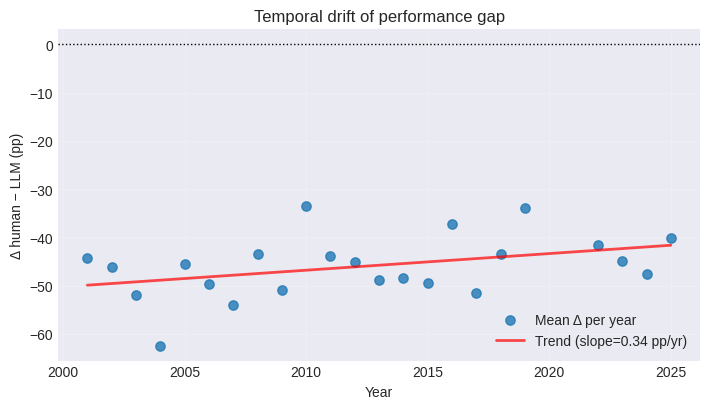

In [31]:
# Minimal plot: mean delta_pp per year with trend line
import numpy as np
import matplotlib.pyplot as plt

if 'comparison_df' not in globals() or comparison_df.empty:
    print('No aligned human/LLM data.')
else:
    x = comparison_df.dropna(subset=['human_pct','llm_pct']).copy()
    x['delta_pp'] = x['human_pct'] - x['llm_pct']
    yr = x.groupby('year')['delta_pp'].mean().reset_index()

    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    ax.scatter(yr['year'], yr['delta_pp'], s=45, color='tab:blue', alpha=0.8, label='Mean Δ per year')
    if len(yr) >= 2:
        z = np.polyfit(yr['year'].values.astype(float), yr['delta_pp'].values.astype(float), 1)
        xl = np.linspace(yr['year'].min(), yr['year'].max(), 100)
        ax.plot(xl, z[0]*xl + z[1], 'r-', linewidth=2, alpha=0.7, label=f'Trend (slope={z[0]:.2f} pp/yr)')
    ax.axhline(0, color='k', linestyle=':', linewidth=1)
    ax.set_xlabel('Year')
    ax.set_ylabel('Δ human − LLM (pp)')
    ax.set_title('Temporal drift of performance gap')
    ax.grid(alpha=0.2)
    ax.legend(loc='best')
    plt.tight_layout()

## Additional Visualizations

In [32]:
# Visualization environment setup
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker

try:
    plt.style.use('seaborn-v0_8')
except OSError:
    plt.style.use('ggplot')


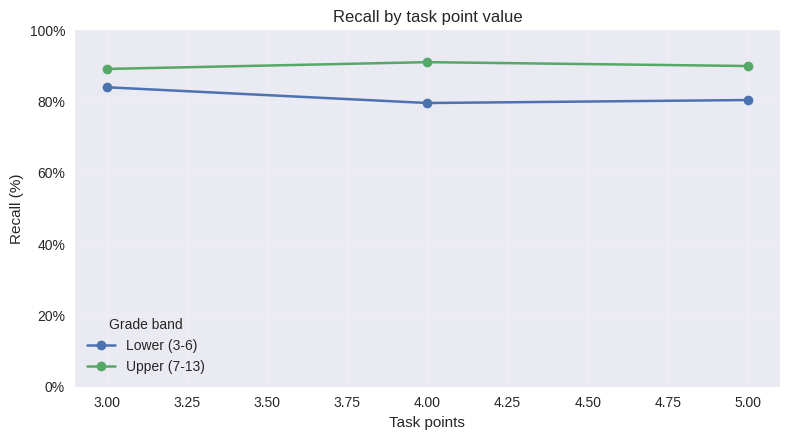

In [33]:
# Recall vs point value per grade band (no attempted-only filtering)
import score_utils
from matplotlib import ticker as mticker

def _infer_primary_grade(group_label):
    numbers = score_utils.extract_grade_numbers(group_label)
    return min(numbers) if numbers else None

def _infer_grade_band(group_label):
    grade = _infer_primary_grade(group_label)
    if grade is None:
        return 'Unknown'
    if 3 <= grade <= 6:
        return 'Lower (3-6)'
    if 7 <= grade <= 13:
        return 'Upper (7-13)'
    return 'Other'

# Use all questions and compute recall per slice
question_stats = df.copy()
question_stats['points'] = pd.to_numeric(question_stats['points'], errors='coerce')
question_stats['problem_number_num'] = pd.to_numeric(question_stats['problem_number'], errors='coerce')
question_stats['grade_band'] = question_stats['group'].apply(_infer_grade_band)

points_summary = (
    question_stats.dropna(subset=['points'])
    .groupby(['grade_band', 'points']).agg(
        total=('answered_correctly', 'size'),
        correct=('answered_correctly', 'sum'),
    )
    .assign(recall=lambda d: d['correct'] / d['total'] * 100)
    .reset_index()
)

if points_summary.empty:
    print('No point-based recall data available.')
else:
    fig, ax = plt.subplots(figsize=(8, 4.5))
    for band, subset in points_summary.groupby('grade_band'):
        ax.plot(
            subset['points'],
            subset['recall'],
            marker='o',
            linewidth=1.8,
            label=band,
        )
    ax.set_xlabel('Task points')
    ax.set_ylabel('Recall (%)')
    ax.set_title('Recall by task point value')
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    ax.grid(alpha=0.2)
    ax.legend(title='Grade band', loc='lower left')
    plt.tight_layout()

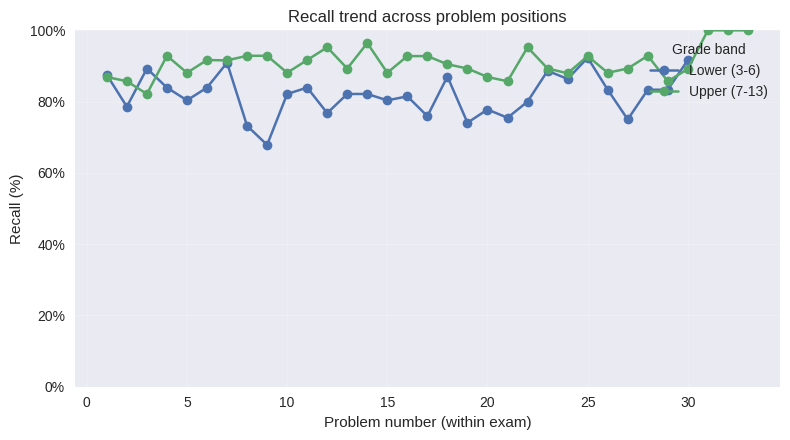

In [34]:
# Recall vs problem position
position_summary = (
    question_stats.dropna(subset=['problem_number_num'])
    .groupby(['grade_band', 'problem_number_num']).agg(
        total=('answered_correctly', 'size'),
        correct=('answered_correctly', 'sum'),
    )
    .assign(recall=lambda d: d['correct'] / d['total'] * 100)
    .reset_index()
)

if position_summary.empty:
    print('No problem position data available.')
else:
    fig, ax = plt.subplots(figsize=(8, 4.5))
    for band, subset in position_summary.groupby('grade_band'):
        subset = subset.sort_values('problem_number_num')
        ax.plot(
            subset['problem_number_num'],
            subset['recall'],
            marker='o',
            linewidth=1.8,
            label=band,
        )
    ax.set_xlabel('Problem number (within exam)')
    ax.set_ylabel('Recall (%)')
    ax.set_title('Recall trend across problem positions')
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    ax.grid(alpha=0.2)
    ax.legend(title='Grade band', loc='upper right')
    plt.tight_layout()

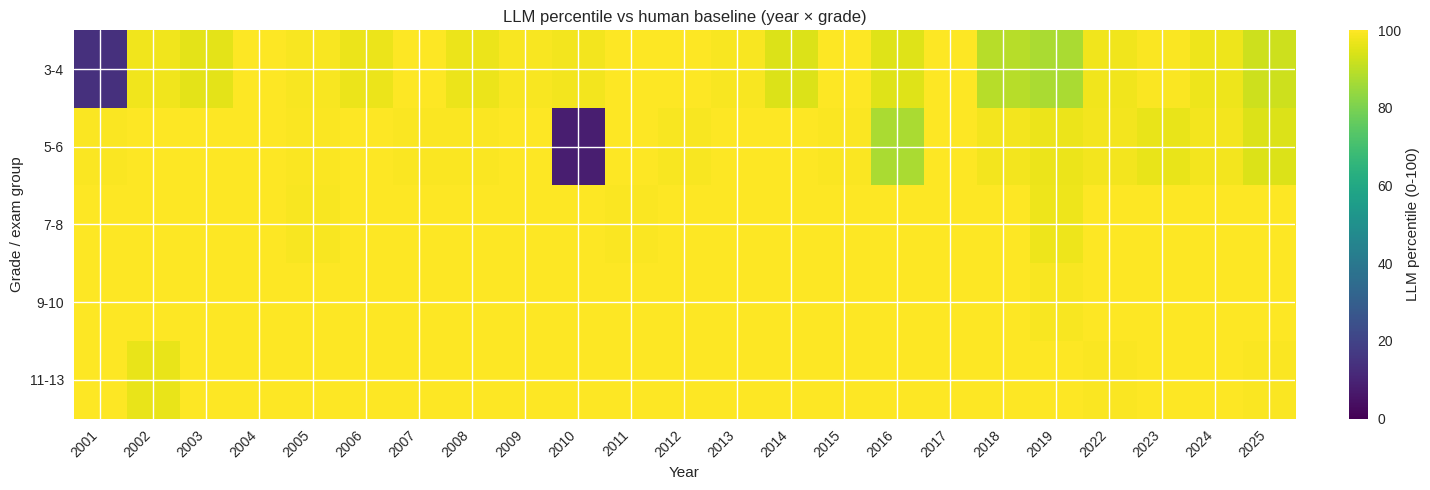

In [35]:
# Heatmap of LLM percentile by year and grade
if comparison_df.empty:
    print('No human comparison data available for heatmap.')
else:
    heatmap_df = comparison_df.copy()
    heatmap_df['year'] = heatmap_df['year'].astype(int)
    heatmap_df['exam'] = heatmap_df['exam'].astype(str)

    pivot = heatmap_df.pivot_table(
        index='exam',
        columns='year',
        values='llm_percentile',
        aggfunc='mean'
    )

    if pivot.empty:
        print('Heatmap pivot is empty.')
    else:
        def _heatmap_sort_key(label):
            nums = score_utils.extract_grade_numbers(label)
            return (min(nums) if nums else 99, label)

        pivot = pivot.reindex(sorted(pivot.index, key=_heatmap_sort_key))
        year_order = sorted(pivot.columns)
        pivot = pivot[year_order]

        data = pivot.to_numpy(dtype=float)
        mask = np.isnan(data)
        data_masked = np.ma.masked_array(data, mask=mask)

        fig_width = max(8, 0.5 * len(year_order) + 3)
        fig_height = max(5, 0.4 * len(pivot.index) + 2)
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))
        cmap = plt.cm.viridis
        cmap.set_bad(color='lightgray')
        im = ax.imshow(data_masked, aspect='auto', cmap=cmap, vmin=0, vmax=100)

        ax.set_xticks(range(len(year_order)))
        ax.set_xticklabels(year_order, rotation=45, ha='right')
        ax.set_yticks(range(len(pivot.index)))
        ax.set_yticklabels(pivot.index)
        ax.set_xlabel('Year')
        ax.set_ylabel('Grade / exam group')
        ax.set_title('LLM percentile vs human baseline (year × grade)')

        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('LLM percentile (0-100)')
        plt.tight_layout()


In [36]:
# Human CDF overlay with LLM score
from typing import Optional

def plot_human_cdf_with_llm(year: int, exam_id: str, *, ax: Optional[plt.Axes] = None) -> Optional[plt.Axes]:
    year = int(year)
    exam_id = str(exam_id)
    human_stats = resolve_human_stats(year, exam_id)
    if not human_stats or human_stats.get('counts') is None:
        print(f'No human distribution data for {year} {exam_id}.')
        return None

    counts = np.asarray(human_stats.get('counts'), dtype=float)
    midpoints = np.asarray(human_stats.get('bin_midpoints'), dtype=float)
    valid_mask = (~np.isnan(counts)) & (~np.isnan(midpoints))
    if valid_mask.sum() == 0:
        print(f'No valid bins to plot for {year} {exam_id}.')
        return None

    scores = midpoints[valid_mask]
    counts = counts[valid_mask]
    order = np.argsort(scores)
    scores = scores[order]
    counts = counts[order]

    cumulative = np.cumsum(counts)
    total = cumulative[-1]
    if total <= 0:
        print(f'Empty human distribution for {year} {exam_id}.')
        return None
    cdf = cumulative / total

    target_ax = ax or plt.subplots(figsize=(7.5, 4.5))[1]
    target_ax.step(scores, cdf, where='post', linewidth=2.2, label='Human CDF')

    row = comparison_df[(comparison_df['year'] == year) & (comparison_df['exam'] == exam_id)]
    if row.empty:
        target_ax.set_title(f'{year} {exam_id}: human CDF (LLM score unavailable)')
    else:
        row = row.iloc[0]
        llm_score = float(row['llm_score']) if pd.notna(row['llm_score']) else None
        llm_max = float(row['llm_max']) if pd.notna(row['llm_max']) else None
        human_max = human_stats.get('max_points')
        if human_max and llm_score is not None and llm_max and human_max != llm_max and llm_max != 0:
            llm_scaled = llm_score / llm_max * human_max
        else:
            llm_scaled = llm_score

        percentile = None
        if llm_scaled is not None:
            percentile = percentile_from_distribution(
                llm_scaled,
                human_stats.get('counts'),
                human_stats.get('bins'),
                human_stats.get('bin_midpoints')
            )
            target_ax.axvline(llm_scaled, color='tab:red', linestyle='--', linewidth=1.8,
                              label=f'LLM score ({percentile:.1f}th pct)' if percentile is not None else 'LLM score')
            if percentile is not None:
                target_ax.axhline(percentile / 100, color='tab:red', linestyle=':', linewidth=1.5)
                target_ax.text(
                    llm_scaled,
                    percentile / 100,
                    f'  {percentile:.1f}%',
                    color='tab:red',
                    va='bottom'
                )
        title_pct = f' – {percentile:.1f}th pct' if percentile is not None else ''
        target_ax.set_title(f'{year} {exam_id}: human CDF vs LLM score{title_pct}')

    target_ax.set_xlabel('Score (scaled to human maximum)')
    target_ax.set_ylabel('Cumulative share of students (≤ score)')
    target_ax.set_ylim(0, 1.02)
    target_ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    target_ax.grid(alpha=0.2)
    target_ax.legend()
    if ax is None:
        plt.tight_layout()
    return target_ax


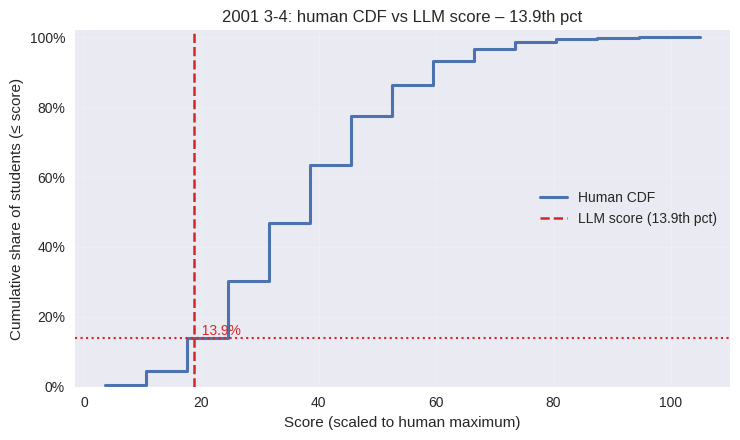

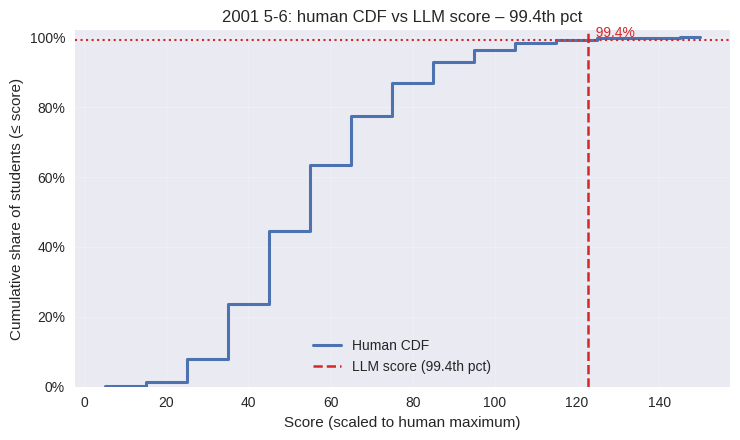

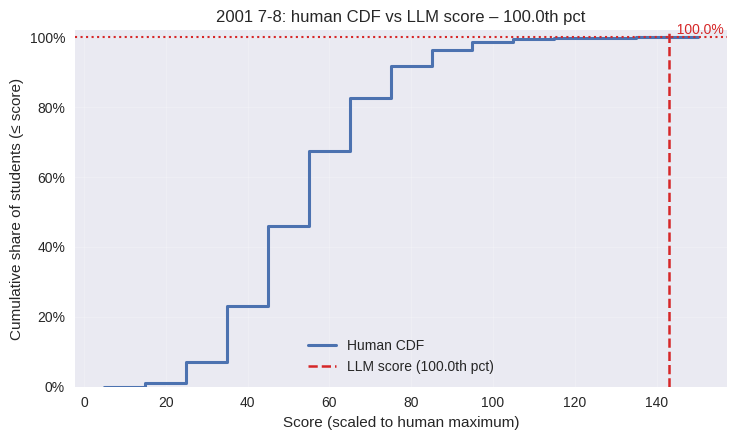

In [37]:
# Example CDF plots for first available exams
if comparison_df.empty:
    print('No LLM-human comparisons available for CDF plots.')
else:
    sample_pairs = comparison_df[['year', 'exam']].drop_duplicates().head(3)
    for _, row in sample_pairs.iterrows():
        plot_human_cdf_with_llm(int(row['year']), str(row['exam']))


/tmp/ipykernel_99982/3958198970.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = scatter_df.groupby(bins).agg(


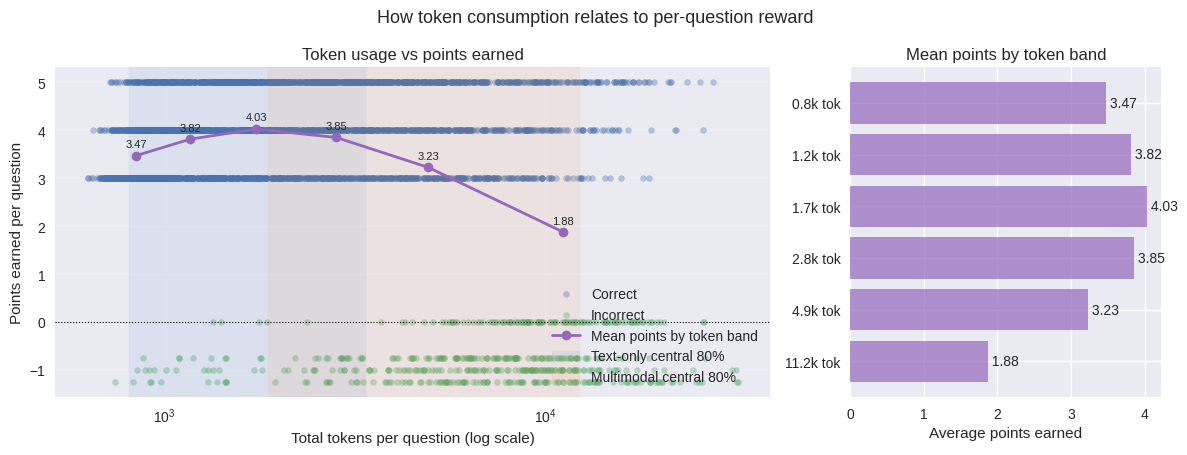

In [38]:
# Token usage vs points earned with bin summaries
required_columns = {'total_tokens', 'points_earned'}
if not required_columns.issubset(question_stats.columns):
    print('Token usage columns missing from dataset.')
else:
    scatter_df = question_stats.dropna(subset=['total_tokens', 'points_earned']).copy()
    if scatter_df.empty:
        print('No token usage data available for scatter plot.')
    else:
        scatter_df['correctness'] = np.where(scatter_df['answered_correctly'], 'Correct', 'Incorrect')
        scatter_df['token_bucket'] = np.where(scatter_df['multimodal'], 'Multimodal', 'Text-only')

        # Bin questions by total tokens (quantiles) to summarise efficiency across usage ranges
        bins = pd.qcut(scatter_df['total_tokens'], q=6, duplicates='drop')
        summary = scatter_df.groupby(bins).agg(
            mean_tokens=('total_tokens', 'mean'),
            median_tokens=('total_tokens', 'median'),
            mean_points=('points_earned', 'mean'),
            count=('points_earned', 'size'),
        ).reset_index(drop=True)
        summary['tokens_per_1k'] = summary['mean_tokens'] / 1000.0

        fig, axes = plt.subplots(1, 2, figsize=(12, 4.6), gridspec_kw={'width_ratios': [2.3, 1]})

        # Scatter plot with log-scale x-axis (captures large spread in usage)
        ax = axes[0]
        for label, subset in scatter_df.groupby('correctness'):
            ax.scatter(
                subset['total_tokens'],
                subset['points_earned'],
                s=18,
                alpha=0.35,
                label=label,
            )
        ax.set_xscale('log')
        ax.set_xlabel('Total tokens per question (log scale)')
        ax.set_ylabel('Points earned per question')
        ax.set_title('Token usage vs points earned')
        ax.axhline(0, color='black', linewidth=0.8, linestyle=':')
        ax.grid(alpha=0.2)

        if not summary.empty:
            ax.plot(
                summary['mean_tokens'],
                summary['mean_points'],
                color='tab:purple',
                marker='o',
                linewidth=2,
                label='Mean points by token band',
            )
            for _, row in summary.iterrows():
                ax.annotate(
                    f"{row['mean_points']:.2f}",
                    (row['mean_tokens'], row['mean_points']),
                    textcoords='offset points',
                    xytext=(0, 6),
                    ha='center',
                    fontsize=8,
                )

        # Highlight typical token ranges (central 80%) for text-only vs multimodal items
        text_tokens = scatter_df.loc[scatter_df['token_bucket'] == 'Text-only', 'total_tokens']
        vision_tokens = scatter_df.loc[scatter_df['token_bucket'] == 'Multimodal', 'total_tokens']
        if not text_tokens.empty:
            ax.axvspan(text_tokens.quantile(0.1), text_tokens.quantile(0.9), color='tab:blue', alpha=0.08, label='Text-only central 80%')
        if not vision_tokens.empty:
            ax.axvspan(vision_tokens.quantile(0.1), vision_tokens.quantile(0.9), color='tab:orange', alpha=0.08, label='Multimodal central 80%')

        ax.legend(loc='lower right')

        # Summary panel: mean points for each token band (helps interpret the scatter)
        ax2 = axes[1]
        if summary.empty:
            ax2.text(0.5, 0.5, 'Insufficient data for summary bins', ha='center', va='center')
            ax2.axis('off')
        else:
            ax2.barh(
                range(len(summary)),
                summary['mean_points'],
                color='tab:purple',
                alpha=0.7,
            )
            ax2.set_yticks(range(len(summary)))
            labels = [f"{row['tokens_per_1k']:.1f}k tok" for _, row in summary.iterrows()]
            ax2.set_yticklabels(labels)
            ax2.set_xlabel('Average points earned')
            ax2.set_title('Mean points by token band')
            for idx, row in summary.iterrows():
                ax2.text(row['mean_points'], idx, f" {row['mean_points']:.2f}", va='center')
            ax2.invert_yaxis()
        fig.suptitle('How token consumption relates to per-question reward', fontsize=13)
        plt.tight_layout()

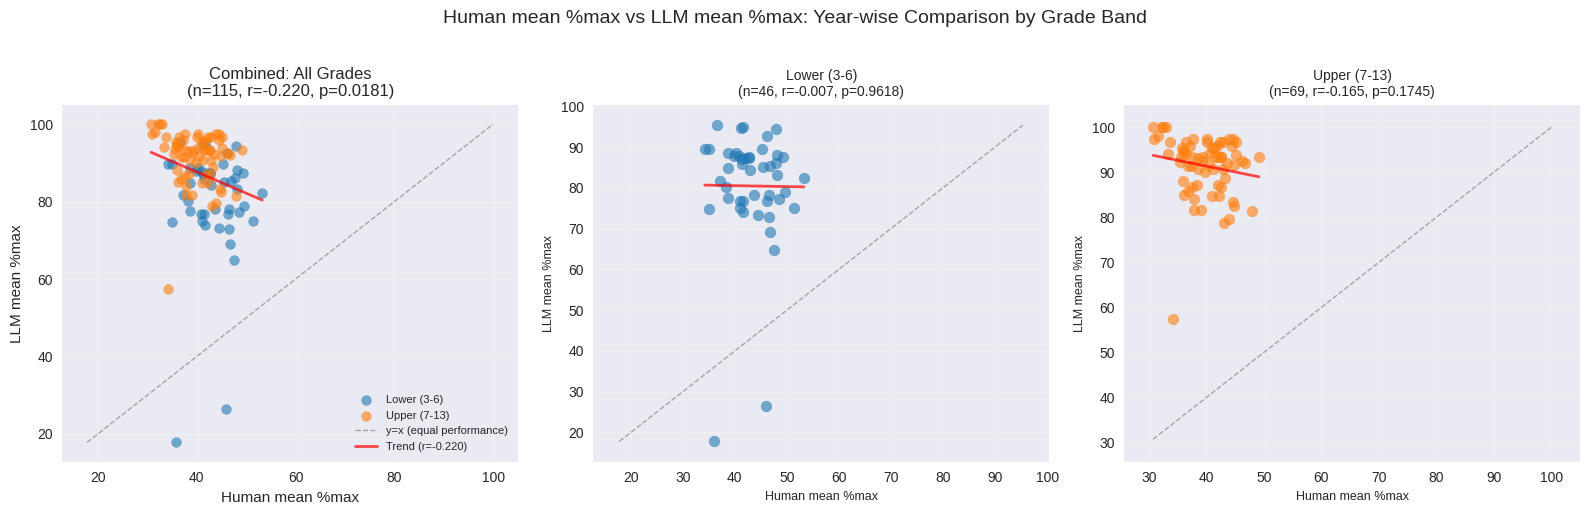


CORRELATION ANALYSIS: Human mean %max vs LLM mean %max

Overall correlation (all grades):
  Pearson r = -0.2201
  p-value = 0.018093
  Sample size = 115
  Regression: y = -0.5492x + 109.6209

Correlation by grade band:

  Lower (3-6):
    Pearson r = -0.0073
    p-value = 0.961849
    Sample size = 46
    Regression: y = -0.0227x + 81.4371

  Upper (7-13):
    Pearson r = -0.1653
    p-value = 0.174536
    Sample size = 69
    Regression: y = -0.2590x + 101.7437



In [39]:
# Year-wise scatter: Human mean %max vs LLM mean %max per grade
# %max = percentage of maximum points scored

if comparison_df.empty:
    print('No comparison data available for scatter plot.')
else:
    # Prepare the data
    scatter_data = comparison_df.copy()
    
    # Ensure we have both human_pct and llm_pct
    scatter_data = scatter_data.dropna(subset=['human_pct', 'llm_pct'])
    
    if scatter_data.empty:
        print('No data with both human and LLM percentages available.')
    else:
        # Extract grade band for color coding
        scatter_data['grade_band'] = scatter_data['exam'].apply(_infer_grade_band)
        
        # Create figure with subplots for each grade band
        grade_bands = scatter_data['grade_band'].unique()
        n_bands = len(grade_bands)
        
        # Create a single combined plot and separate plots by grade band
        fig = plt.figure(figsize=(16, 5))
        
        # Combined plot
        ax_combined = plt.subplot(1, n_bands + 1, 1)
        
        colors = {'Lower (3-6)': 'tab:blue', 'Upper (7-13)': 'tab:orange', 'Other': 'tab:green', 'Unknown': 'tab:gray'}
        
        for band in grade_bands:
            band_data = scatter_data[scatter_data['grade_band'] == band]
            ax_combined.scatter(
                band_data['human_pct'],
                band_data['llm_pct'],
                s=50,
                alpha=0.6,
                color=colors.get(band, 'tab:gray'),
                label=band
            )
        
        # Add diagonal reference line (y = x, where LLM = Human)
        max_val = max(scatter_data['human_pct'].max(), scatter_data['llm_pct'].max())
        min_val = min(scatter_data['human_pct'].min(), scatter_data['llm_pct'].min())
        ax_combined.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, linewidth=1, label='y=x (equal performance)')
        
        # Calculate overall trend line and correlation
        from scipy import stats
        x = scatter_data['human_pct'].values
        y = scatter_data['llm_pct'].values
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        # Plot trend line
        x_trend = np.linspace(x.min(), x.max(), 100)
        y_trend = slope * x_trend + intercept
        ax_combined.plot(x_trend, y_trend, 'r-', linewidth=2, alpha=0.7, label=f'Trend (r={r_value:.3f})')
        
        ax_combined.set_xlabel('Human mean %max')
        ax_combined.set_ylabel('LLM mean %max')
        ax_combined.set_title(f'Combined: All Grades\n(n={len(scatter_data)}, r={r_value:.3f}, p={p_value:.4f})')
        ax_combined.grid(alpha=0.2)
        ax_combined.legend(loc='best', fontsize=8)
        ax_combined.set_xlim(min_val - 5, max_val + 5)
        ax_combined.set_ylim(min_val - 5, max_val + 5)
        
        # Individual plots by grade band
        for idx, band in enumerate(sorted(grade_bands), start=2):
            ax = plt.subplot(1, n_bands + 1, idx)
            band_data = scatter_data[scatter_data['grade_band'] == band]
            
            ax.scatter(
                band_data['human_pct'],
                band_data['llm_pct'],
                s=60,
                alpha=0.6,
                color=colors.get(band, 'tab:gray')
            )
            
            # Add diagonal reference line
            band_max = max(band_data['human_pct'].max(), band_data['llm_pct'].max())
            band_min = min(band_data['human_pct'].min(), band_data['llm_pct'].min())
            ax.plot([band_min, band_max], [band_min, band_max], 'k--', alpha=0.3, linewidth=1)
            
            # Calculate band-specific trend line and correlation
            if len(band_data) > 2:
                x_band = band_data['human_pct'].values
                y_band = band_data['llm_pct'].values
                slope_b, intercept_b, r_value_b, p_value_b, std_err_b = stats.linregress(x_band, y_band)
                
                # Plot trend line
                x_trend_b = np.linspace(x_band.min(), x_band.max(), 100)
                y_trend_b = slope_b * x_trend_b + intercept_b
                ax.plot(x_trend_b, y_trend_b, 'r-', linewidth=2, alpha=0.7)
                
                ax.set_title(f'{band}\n(n={len(band_data)}, r={r_value_b:.3f}, p={p_value_b:.4f})', fontsize=10)
            else:
                ax.set_title(f'{band}\n(n={len(band_data)}, insufficient data)', fontsize=10)
            
            ax.set_xlabel('Human mean %max', fontsize=9)
            ax.set_ylabel('LLM mean %max', fontsize=9)
            ax.grid(alpha=0.2)
            ax.set_xlim(band_min - 5, band_max + 5)
            ax.set_ylim(band_min - 5, band_max + 5)
        
        plt.suptitle('Human mean %max vs LLM mean %max: Year-wise Comparison by Grade Band', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Print correlation statistics
        print("\n" + "=" * 80)
        print("CORRELATION ANALYSIS: Human mean %max vs LLM mean %max")
        print("=" * 80)
        print(f"\nOverall correlation (all grades):")
        print(f"  Pearson r = {r_value:.4f}")
        print(f"  p-value = {p_value:.6f}")
        print(f"  Sample size = {len(scatter_data)}")
        print(f"  Regression: y = {slope:.4f}x + {intercept:.4f}")
        
        print("\nCorrelation by grade band:")
        for band in sorted(grade_bands):
            band_data = scatter_data[scatter_data['grade_band'] == band]
            if len(band_data) > 2:
                x_band = band_data['human_pct'].values
                y_band = band_data['llm_pct'].values
                slope_b, intercept_b, r_value_b, p_value_b, std_err_b = stats.linregress(x_band, y_band)
                print(f"\n  {band}:")
                print(f"    Pearson r = {r_value_b:.4f}")
                print(f"    p-value = {p_value_b:.6f}")
                print(f"    Sample size = {len(band_data)}")
                print(f"    Regression: y = {slope_b:.4f}x + {intercept_b:.4f}")
            else:
                print(f"\n  {band}:")
                print(f"    Sample size = {len(band_data)} (insufficient for correlation)")
        
        print("\n" + "=" * 80)


,group,n,r,slope,Δmean_pp,Δmedian_pp
0,Overall,115,-0.220,-0.088,-45.98,-47.98
1,Lower (3-6),46,-0.007,-0.002,-37.29,-39.66
2,Upper (7-13),69,-0.165,-0.106,-51.76,-52.25


Note: lower LLM %max implies harder exam; Δ > 0 means humans > LLM.


/tmp/ipykernel_99982/2494165841.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(bp_data, vert=True, labels=[b.replace(' (','(') for b in plot_bands], patch_artist=True, boxprops=dict(facecolor='lightgray', alpha=0.6))


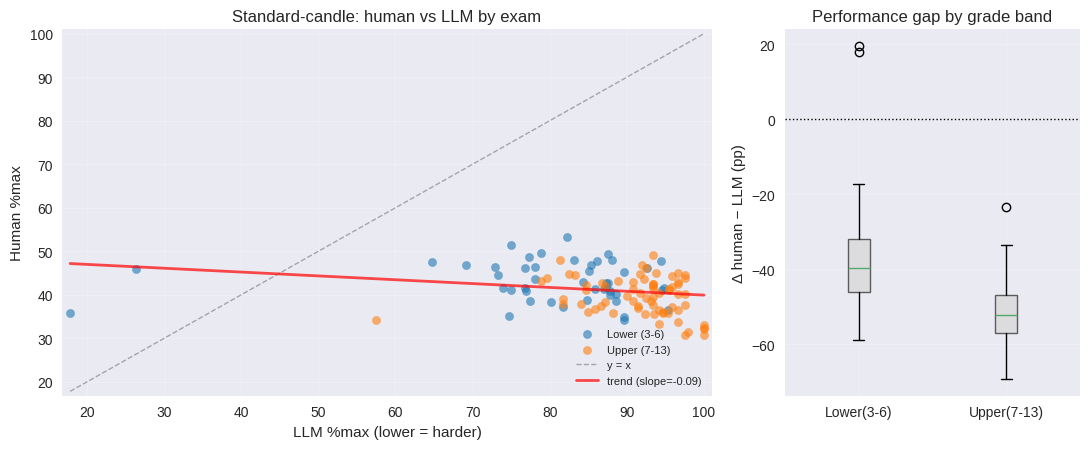

In [40]:

# Standard-Candle: Humans vs LLM-derived difficulty (refined)
# Compact summary table + concise visual (scatter + boxplot).
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import score_utils

def _grade_band(exam_id):
    nums = score_utils.extract_grade_numbers(exam_id)
    g = min(nums) if nums else None
    if g is None: return 'Unknown'
    return 'Lower (3-6)' if 3 <= g <= 6 else ('Upper (7-13)' if 7 <= g <= 13 else 'Other')

if 'comparison_df' not in globals() or comparison_df.empty:
    print('Standard-candle: skipped (no aligned human/LLM data).')
else:
    data = comparison_df.dropna(subset=['human_pct','llm_pct']).copy()
    if data.empty:
        print('Standard-candle: skipped (insufficient data).')
    else:
        data['grade_band'] = data['exam'].apply(_grade_band)
        data['delta_pp'] = data['human_pct'] - data['llm_pct']

        def _stats(df):
            x = df['llm_pct'].to_numpy(); y = df['human_pct'].to_numpy(); n = len(df)
            if n > 1:
                r = float(np.corrcoef(x, y)[0,1]); slope, intercept = np.polyfit(x, y, 1)
            else:
                r, slope, intercept = np.nan, np.nan, np.nan
            return {'n': n, 'r': r, 'slope': slope, 'Δmean_pp': df['delta_pp'].mean(), 'Δmedian_pp': df['delta_pp'].median()}

        rows = [{'group': 'Overall', **_stats(data)}]
        for band, g in data.groupby('grade_band'):
            rows.append({'group': band, **_stats(g)})
        summary = pd.DataFrame(rows)
        for col in ['r','slope','Δmean_pp','Δmedian_pp']:
            summary[col] = summary[col].round(3 if col in ('r','slope') else 2)
        display(summary[['group','n','r','slope','Δmean_pp','Δmedian_pp']])

        # Visual: scatter (LLM vs Human) + boxplot of Δ by grade band
        bands = ['Lower (3-6)','Upper (7-13)','Other','Unknown']
        colors = {'Lower (3-6)':'tab:blue','Upper (7-13)':'tab:orange','Other':'tab:green','Unknown':'tab:gray'}
        fig, axes = plt.subplots(1, 2, figsize=(11, 4.6), gridspec_kw={'width_ratios': [2.2, 1]})
        ax = axes[0]
        for b in bands:
            sub = data[data['grade_band'] == b]
            if sub.empty: continue
            ax.scatter(sub['llm_pct'], sub['human_pct'], s=35, alpha=0.6, label=b, color=colors.get(b,'tab:gray'))
        mn = min(data['llm_pct'].min(), data['human_pct'].min()); mx = max(data['llm_pct'].max(), data['human_pct'].max())
        ax.plot([mn, mx], [mn, mx], 'k--', linewidth=1, alpha=0.3, label='y = x')
        x = data['llm_pct'].to_numpy(); y = data['human_pct'].to_numpy()
        if len(x) > 1:
            slope, intercept = np.polyfit(x, y, 1); xline = np.linspace(mn, mx, 100)
            ax.plot(xline, slope*xline + intercept, 'r-', linewidth=2, alpha=0.7, label=f'trend (slope={slope:.2f})')
        ax.set_xlabel('LLM %max (lower = harder)')
        ax.set_ylabel('Human %max')
        ax.set_title('Standard-candle: human vs LLM by exam')
        ax.grid(alpha=0.2); ax.legend(loc='lower right', fontsize=8)
        ax.set_xlim(mn-1, mx+1); ax.set_ylim(mn-1, mx+1)

        ax2 = axes[1]
        plot_bands = [b for b in bands if not data[data['grade_band'] == b].empty]
        bp_data = [data.loc[data['grade_band'] == b, 'delta_pp'] for b in plot_bands]
        ax2.boxplot(bp_data, vert=True, labels=[b.replace(' (','(') for b in plot_bands], patch_artist=True, boxprops=dict(facecolor='lightgray', alpha=0.6))
        ax2.axhline(0, color='k', linestyle=':', linewidth=1)
        ax2.set_ylabel('Δ human − LLM (pp)')
        ax2.set_title('Performance gap by grade band')
        ax2.grid(alpha=0.2)
        plt.tight_layout()

        print('Note: lower LLM %max implies harder exam; Δ > 0 means humans > LLM.')
